In [3]:
import os                                  #Hello2021
os.environ["OMP_NUM_THREADS"] = "8"        #"export" OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8"   #"export" OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "8"        #"export" MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" #"export" VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "8"    #Hello2021

## Imports

In [4]:
import io
import os
import gzip
import json
import scipy
import random
import warnings
import numpy as np
import numba as nb
import pandas as pd
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as st
from collections import OrderedDict
import scipy.sparse as sparse
from scipy.linalg import orth
import matplotlib.pyplot as plt
from numpy import linalg as lin
import implicit
import pickle
warnings.filterwarnings('ignore')
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from datetime import datetime as dt_dt
from scipy.sparse.linalg import spsolve
from numpy.linalg import qr as QR_decomp
from scipy.sparse import csr_matrix, find
from pandas.api.types import CategoricalDtype
from typing import List
import torch
import torch.nn.functional as F
from torch import nn
from polara.evaluation.pipelines import random_grid
import bottleneck as bn

## Functions

In [5]:
import sys
sys.path.append('/home/oolaleke/incremental_PSI/Scripts/')
#sys.path.append('/content/')

In [6]:
import a_DataHelpers
import b_AlgoFunctions
import c_PredEval
import d_CorrScores
import e_VAEfunction

In [7]:
from a_DataHelpers import getPivotMonths,Time_DataSplit,TestTrain_DataSplit,SingleRatingMatrix
from a_DataHelpers import AllRatingMatrices,All_SingleStepRatMat,psiStep_RatMat,psiAllStep_RatMat
from a_DataHelpers import Find_NewUsersItems,adjustedPSI_DF,adjustedAllDF,get_NEWHoldout,ADJUST_mainDF
from a_DataHelpers import  SingleStepRatMat_2,AllSingleStepRatMat_2

from b_AlgoFunctions import integrator,getStartingValues,integratorOnMat,last_psiTrainMat, pureSVD
from b_AlgoFunctions import Updt_RowMatrix,getRow_Mat,row_update, Updt_ColMatrix,getCol_Mat,colunm_update
from b_AlgoFunctions import UsersItems_RatPair,getRowCol_psiupdt,ITEMS_defferredStatus,USERS_defferredStatus
from b_AlgoFunctions import getV_listUpdate, SingleStep_UPDATE,ALLSTEPs_UPDATE, auc_score,TrainTest
from b_AlgoFunctions import mean_auc,tune_ALS,nonzeros,least_squares_cg,alternating_least_squares_cg

from c_PredEval import TopNPred,TQDMgetALLTopNPred, Hitrate_Eval,getAll_HitRate,mean_confidence_interval
from c_PredEval import TQDMgetALLTopNPred_ALLUSERS,getALLTopNPred_ALLUSERS,get_ALLRandPred
from c_PredEval import topN_Index,getAll_RandomHitRate,getMOSTPOP_Pred,getAll_MostPOPHitRate,getAll_MOSTPOP_Pred
from c_PredEval import StepCoverage_Ratio,AllSteps_Coverage_Ratio,getAll_VAEMRR, MRR_Eval,getAll_MRR_Eval
from c_PredEval import TQDMgetAll_MRR_Eval, getAll_MostPOP_MRR,getAll_RandomRecMRR, ials_TopNPred,ials_getALLPred
from c_PredEval import ials_getALLPredTQDM,ials_ALLUSERSpred,ialsALLPred_ALLUSERS,TQDM_ialsALLPred_ALLUSERS

from d_CorrScores import no_copy_csr_matrix,build_rank_weights_matrix,rank_weighted_jaccard_index
from d_CorrScores import Updt_getAll_AvgCorr, updtCorr_4AllRanks

from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat


## Apply Functions on *MovieLenDF*

### Import Clean Data 

In [9]:
#MLDF_20M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/newIncreMLDF_20M.csv.zip') 
MLDF_20M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/MLDF_20M.csv.zip') 
MLDF_20M['timestamp'] = pd.to_datetime(MLDF_20M['timestamp']) 
print(MLDF_20M.shape)   #
print(MLDF_20M.dtypes)
MLDF_20M

(9990682, 7)
userid                   int64
movieId                  int64
rating                   int64
timestamp       datetime64[ns]
timestamp_YM            object
userId                   int64
productId                int64
dtype: object


,userid,movieId,rating,timestamp,timestamp_YM,userId,productId
0,28507,1176,1,1995-01-09 11:46:44,1995-01,0,0
1,131160,47,1,1995-01-09 11:46:49,1995-01,1,1
2,85252,70,1,1996-01-29 00:00:00,1996-01,2,2
3,134445,45,1,1996-01-29 00:00:00,1996-01,3,3
4,99851,10,1,1996-01-29 00:00:00,1996-01,4,4
...,...,...,...,...,...,...,...
9990677,57814,3527,1,2015-03-31 05:44:17,2015-03,136366,3314
9990678,57814,48774,1,2015-03-31 05:44:23,2015-03,136366,9045
9990679,57814,1240,1,2015-03-31 05:50:01,2015-03,136366,1073
9990680,57814,2311,1,2015-03-31 05:51:23,2015-03,136366,2129


In [11]:
print(MLDF_20M.shape)
print("For users: ")
print(MLDF_20M['userId'].nunique())
print(MLDF_20M['userId'].max())
print()
print("For items: ")
print(MLDF_20M['productId'].nunique())
print(MLDF_20M['productId'].max())
print()
print("Timestamp")
print(MLDF_20M['timestamp'].min())
print(MLDF_20M['timestamp'].max())

(9990682, 7)
For users: 
136677
136676

For items: 
20720
20719

Timestamp
1995-01-09 11:46:44
2015-03-31 06:11:28


In [38]:
nunsers = MLDF_20M['userId'].nunique()
nitems = MLDF_20M['productId'].nunique()
print("Num of unique users: ",nunsers)
print("Num of unique items: ",nitems)
print()
sparsity = (1. * MLDF_20M.shape[0]) / (nunsers * nitems)
print("After filtering, there are %d inyteractions from %d users and %d items (sparsity: %.3f%%)" % 
      (MLDF_20M.shape[0], nunsers, nitems, sparsity * 100))

Num of unique users:  136677
Num of unique items:  20720

After filtering, there are 9990682 inyteractions from 136677 users and 20720 items (sparsity: 0.353%)


### Data Split

In [12]:
print("Size of Dataset: ", MLDF_20M.shape)
print('Min Date: ', MLDF_20M['timestamp'].min())
print("Max Date: ",MLDF_20M['timestamp'].max())

Size of Dataset:  (9990682, 7)
Min Date:  1995-01-09 11:46:44
Max Date:  2015-03-31 06:11:28


In [14]:
train_df = MLDF_20M[MLDF_20M['timestamp_YM'] < '2010-01']    #'2016-02
print("DF Shape: ",train_df['userId'].shape)  ##63%
print("NUsers  : ",train_df['userId'].nunique())
print("max Ids  : ",train_df['userId'].max(),train_df['productId'].max())

DF Shape:  (8066566,)
NUsers  :  112109
max Ids  :  112108 12063


In [17]:
remainder_df = MLDF_20M[MLDF_20M['timestamp_YM'] >= '2010-01']  
print("DF Shape: ",remainder_df['userId'].shape)  ##63%
print("NUsers  : ",remainder_df['userId'].nunique())
#print("max Ids  : ",remainder_df['userId'].min(),remainder_df['productId'].min())

DF Shape:  (1924116,)
NUsers  :  30094


In [18]:
n = 80200  #num_of_interaction/no_steps
all_df = []
for g, df in remainder_df.groupby(np.arange(len(remainder_df)) // n):
    all_df.append(df)
    print(df['userId'].nunique())
print()
print(g+1)    

3322
3482
3194
3142
3224
3536
3559
3263
3562
3459
3311
3124
3115
3165
3098
3169
3129
3192
3409
3267
3077
2772
2644
2730

24


In [21]:
for i in range(5):
    print(all_df[i]['timestamp'].min()) 
    print(all_df[i]['timestamp'].max())
    print()

2010-01-01 00:01:13
2010-03-08 08:53:21

2010-03-08 08:53:27
2010-05-27 20:50:21

2010-05-27 20:51:00
2010-08-07 17:30:17

2010-08-07 17:30:18
2010-10-01 02:39:05

2010-10-01 02:39:10
2010-12-03 14:19:53



###Traintest Split

In [22]:
A0_df = train_df  
print("Initial Training Data: ") 
print("Start Time: ",A0_df['timestamp'].min())
print("End Time:   ",A0_df['timestamp'].max())
print()
print("Num of interactions: ",A0_df.shape[0])
print("Num of uniqueUsers:  ",A0_df['userId'].nunique())

Initial Training Data: 
Start Time:  1995-01-09 11:46:44
End Time:    2009-12-31 23:59:17

Num of interactions:  8066566
Num of uniqueUsers:   112109


In [23]:
print("max of userId     :  ",A0_df['userId'].max())
print("max of productId  :  ",A0_df['productId'].max())

max of userId     :   112108
max of productId  :   12063


In [24]:
ΔA_train = all_df[:9] 
print("Incremental Train steps: ",len(ΔA_train))
print("Start Time: ",ΔA_train[0]['timestamp'].min())
print("End Time:   ",ΔA_train[-1]['timestamp'].max())


Incremental Train steps:  9
Start Time:  2010-01-01 00:01:13
End Time:    2011-09-20 19:46:58


In [26]:
ΔA_test = all_df[9:] 
print("Incremental Test steps: ",len(ΔA_test))
print("Start Time: ",ΔA_test[0]['timestamp'].min())
print("End Time:   ",ΔA_test[-1]['timestamp'].max())

Incremental Test steps:  15
Start Time:  2011-09-20 19:47:28
End Time:    2015-03-31 06:11:28


In [27]:
ΔA_test[0]['timestamp'].max()

Timestamp('2011-12-24 12:40:43')

In [28]:
ML20M_DF = MLDF_20M

In [29]:
AllDF_list, PSITest_list, HOLDOUT_list,UserItemDF_list = TestTrain_DataSplit(ML20M_DF,'userId','timestamp',ΔA_test)
print(AllDF_list[1]['timestamp'].min())
print(AllDF_list[1]['timestamp'].max())
print()
print(ΔA_test[1]['timestamp'].min())
print(ΔA_test[1]['timestamp'].max())

1995-01-09 11:46:44
2012-03-16 20:45:10

2011-12-24 12:40:45
2012-03-16 20:45:10


In [30]:
for i in range(10):
    print(AllDF_list[i]['userId'].max(),AllDF_list[i]['userId'].nunique())

122396 122397
123312 123313
124423 124424
125345 125346
126344 126345
127270 127271
128218 128219
129236 129237
130491 130492
131632 131633


In [31]:
print(ΔA_test[2].shape)
print(PSITest_list[2].shape)
print(HOLDOUT_list[2]['userId'].nunique())

(80200, 7)
(77076, 7)
3124


### Find new users and items

In [32]:
Tstps = ML20M_DF['timestamp']
tr_ts = ΔA_train[-1]['timestamp'].max()
print("ΔA_train_last max date: ",tr_ts)
AllDF_start = ML20M_DF.loc[Tstps <= tr_ts] 
print(AllDF_start['timestamp'].min())
print(AllDF_start['timestamp'].max())
print()
print(AllDF_list[0]['timestamp'].min())
print(AllDF_list[0]['timestamp'].max())

ΔA_train_last max date:  2011-09-20 19:46:58
1995-01-09 11:46:44
2011-09-20 19:46:58

1995-01-09 11:46:44
2011-12-24 12:40:43


In [33]:
len(ΔA_test)

15

In [34]:
New_usersList,New_itemsList = Find_NewUsersItems(AllDF_start,AllDF_list,'userId','productId',N_steps=15)
print(New_usersList[0][:10]) #
print()
print(New_itemsList[0][:10]) #

[121304 121305 121306 121307 121308 121309 121310 121311 121312 121313]

[14959 14960 14961 14962 14963 14964 14965 14966 14967 14968]


In [35]:
print("users,Items")
for i,j in zip(New_usersList,New_itemsList):
    print(i.size,j.size)
    print()
    

users,Items
1093 339

916 305

1111 276

922 304

999 350

926 329

948 362

1018 345

1255 388

1141 425

1180 444

1015 400

952 477

873 535

1024 482



In [40]:
print(AllDF_start['userId'].max())
New_usersList[0]

121303


array([121304, 121305, 121306, ..., 122394, 122395, 122396])

## Incre Update

###Get Updt RatMat

In [42]:
print(AllDF_start['userId'].nunique())
print(A0_df['timestamp'].max())
print(AllDF_start['timestamp'].max())

121304
2009-12-31 23:59:17
2011-09-20 19:46:58


In [43]:
rows_i = AllDF_start['userId'].nunique()
cols_i = AllDF_start['productId'].nunique()
print(A0_df.shape)
A0_RatMat_updt = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)
A0_RatMat_updt

(8066566, 7)


<121304x14959 sparse matrix of type '<class 'numpy.float64'>'
	with 8066566 stored elements in Compressed Sparse Row format>

In [44]:
PSI_TrainMat_updt = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_TrainMat_updt

[<121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row f

### Allsteps Update

In [ ]:
# rows_i = AllDF_start['userId'].nunique()
# cols_i = AllDF_start['productId'].nunique()
# print(AllDF_start.shape)
# AllDF_startRatMat = SingleRatingMatrix(AllDF_start,'userId', 'productId',rows_i,cols_i)

# U_start,S_start,V_start = svds(AllDF_startRatMat,k=50)
# V_start = V_start.T
# print()
# print("U_start shape: ",U_start.shape)
# print("S_start shape: ",S_start.shape)
# print("V_start shape: ",V_start.shape)

In [45]:
U_start,S_start,V_start = last_psiTrainMat(A0_RatMat_updt,PSI_TrainMat_updt,k=50)
print()
print("U_start shape: ",U_start.shape)
print("S_start shape: ",S_start.shape)
print("V_start shape: ",V_start.shape)

100%|██████████| 9/9 [00:01<00:00,  5.59it/s]
U_start shape:  (121304, 50)
S_start shape:  (50, 50)
V_start shape:  (14959, 50)



In [46]:
U_list,S_list,V_list = [],[],[]
U_list.append(U_start)
S_list.append(S_start)
V_list.append(V_start)
print(len(U_list),len(V_list))

1 1


In [47]:
DItems_, DUsers_,In_DomainUSERS,In_DomainITEMS,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,U_list,S_list,V_list = ALLSTEPs_UPDATE(AllDF_start,AllDF_list,New_itemsList,New_usersList,U_list,
                                       S_list,V_list,'userId','productId',Nsteps=15,k=50,Forced_Orth=False)

100%|██████████| 14/14 [31:03<00:00, 133.11s/it]


### Output Check

In [48]:
print(AllDF_start['productId'].max())
print(AllDF_start['userId'].max())

14958
121303


In [49]:
print(len(In_DomainITEMS[14958+1:]))
print(In_DomainITEMS[14958+1:][:10])
print()
print(len(In_DomainUSERS[121303+1:]))
print(In_DomainUSERS[121303+1:][:10])

5761
[14959, 14960, 14961, 14962, 14963, 14965, 14966, 14967, 14968, 14969]

15373
[121304, 121305, 121306, 121307, 121308, 121309, 121310, 121311, 121312, 121313]


In [52]:
#deferred items and users
print(len(DItems_))
print(DItems_[:10])
print()
print(len(DUsers_))
print(DUsers_[:10])

0
[]

0
[]


In [53]:
for x in list(itemID_dict)[3477+1:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  itemID_dict[x]))   ##id ==key || updtedid == values  ,itemID_dict

Id: 3478, UpdtId: 3478 
Id: 3479, UpdtId: 3479 
Id: 3480, UpdtId: 3480 
Id: 3481, UpdtId: 3481 
Id: 3482, UpdtId: 3482 
Id: 3483, UpdtId: 3483 
Id: 3484, UpdtId: 3484 
Id: 3485, UpdtId: 3485 
Id: 3486, UpdtId: 3486 
Id: 3487, UpdtId: 3487 
Id: 3488, UpdtId: 3488 
Id: 3489, UpdtId: 3489 
Id: 3490, UpdtId: 3490 
Id: 3491, UpdtId: 3491 
Id: 3492, UpdtId: 3492 
Id: 3493, UpdtId: 3493 
Id: 3494, UpdtId: 3494 
Id: 3495, UpdtId: 3495 
Id: 3496, UpdtId: 3496 
Id: 3497, UpdtId: 3497 
Id: 3498, UpdtId: 3498 
Id: 3499, UpdtId: 3499 
Id: 3500, UpdtId: 3500 
Id: 3501, UpdtId: 3501 
Id: 3502, UpdtId: 3502 
Id: 3503, UpdtId: 3503 
Id: 3504, UpdtId: 3504 
Id: 3505, UpdtId: 3505 
Id: 3506, UpdtId: 3506 
Id: 3507, UpdtId: 3507 
Id: 3508, UpdtId: 3508 
Id: 3509, UpdtId: 3509 
Id: 3510, UpdtId: 3510 
Id: 3511, UpdtId: 3511 
Id: 3512, UpdtId: 3512 
Id: 3513, UpdtId: 3513 
Id: 3514, UpdtId: 3514 
Id: 3515, UpdtId: 3515 
Id: 3516, UpdtId: 3516 
Id: 3517, UpdtId: 3517 
Id: 3518, UpdtId: 3518 
Id: 3519, UpdtId

In [54]:
for x in list(userID_dict)[5710:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  userID_dict[x]))   ##id ==key || updtedid == values 

Id: 5710, UpdtId: 5710 
Id: 5711, UpdtId: 5711 
Id: 5712, UpdtId: 5712 
Id: 5713, UpdtId: 5713 
Id: 5714, UpdtId: 5714 
Id: 5715, UpdtId: 5715 
Id: 5716, UpdtId: 5716 
Id: 5717, UpdtId: 5717 
Id: 5718, UpdtId: 5718 
Id: 5719, UpdtId: 5719 
Id: 5720, UpdtId: 5720 
Id: 5721, UpdtId: 5721 
Id: 5722, UpdtId: 5722 
Id: 5723, UpdtId: 5723 
Id: 5724, UpdtId: 5724 
Id: 5725, UpdtId: 5725 
Id: 5726, UpdtId: 5726 
Id: 5727, UpdtId: 5727 
Id: 5728, UpdtId: 5728 
Id: 5729, UpdtId: 5729 
Id: 5730, UpdtId: 5730 
Id: 5731, UpdtId: 5731 
Id: 5732, UpdtId: 5732 
Id: 5733, UpdtId: 5733 
Id: 5734, UpdtId: 5734 
Id: 5735, UpdtId: 5735 
Id: 5736, UpdtId: 5736 
Id: 5737, UpdtId: 5737 
Id: 5738, UpdtId: 5738 
Id: 5739, UpdtId: 5739 
Id: 5740, UpdtId: 5740 
Id: 5741, UpdtId: 5741 
Id: 5742, UpdtId: 5742 
Id: 5743, UpdtId: 5743 
Id: 5744, UpdtId: 5744 
Id: 5745, UpdtId: 5745 
Id: 5746, UpdtId: 5746 
Id: 5747, UpdtId: 5747 
Id: 5748, UpdtId: 5748 
Id: 5749, UpdtId: 5749 
Id: 5750, UpdtId: 5750 
Id: 5751, UpdtId

In [55]:
print(len(U_list),len(V_list))
print(U_list[0].shape,V_list[0].shape)
print()
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape,v.shape)   

16 16
(121304, 50) (14959, 50)

(122397, 50) (15298, 50)
(123313, 50) (15603, 50)
(124424, 50) (15879, 50)
(125346, 50) (16183, 50)
(126345, 50) (16533, 50)
(127271, 50) (16862, 50)
(128219, 50) (17224, 50)
(129237, 50) (17569, 50)
(130492, 50) (17957, 50)
(131633, 50) (18382, 50)
(132813, 50) (18826, 50)
(133828, 50) (19226, 50)
(134780, 50) (19703, 50)
(135653, 50) (20238, 50)
(136677, 50) (20720, 50)


In [56]:
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

122397 15298
123313 15603
124424 15879
125346 16183
126345 16533
127271 16862
128219 17224
129237 17569
130492 17957
131633 18382
132813 18826
133828 19226
134780 19703
135653 20238
136677 20720


In [58]:
print(len(In_DomainUSERS),len(In_DomainITEMS))
print(ML20M_DF['userId'].nunique(),ML20M_DF['productId'].nunique())

136677 20720
136677 20720


Data Adjustments

### Data Adjustment

In [59]:
len(AllUpdtITEMS_)

15

In [60]:
newHOLDOUT_LIST = get_NEWHoldout(HOLDOUT_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(len(newHOLDOUT_LIST))
print()
for old,new in zip(HOLDOUT_list,newHOLDOUT_LIST):
    print(old.shape[0],new.shape[0])

15it [00:00, 25.98it/s]15

3459 3459
3311 3311
3124 3124
3115 3115
3165 3165
3098 3098
3169 3169
3129 3129
3192 3192
3409 3409
3267 3267
3077 3077
2772 2772
2644 2644
2730 2730



In [61]:
newUserItem_list = adjustedAllDF(UserItemDF_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print()
for df in newUserItem_list:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

15it [02:27,  9.85s/it]

122396 15297
123312 15600
124423 15878
125345 16182
126344 16531
127270 16861
128217 17223
129236 17568
130491 17956
131632 18381
132812 18825
133827 19225
134779 19702
135652 20237
136676 20719


In [62]:
new_PSIDFlist = adjustedPSI_DF(PSITest_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
for old,new in zip(PSITest_list,new_PSIDFlist):
    print(old.shape[0],new.shape[0])

15it [00:01,  7.78it/s]76741 76741
76889 76889
77076 77076
77085 77085
77035 77035
77102 77102
77031 77031
77071 77071
77008 77008
76791 76791
76933 76933
77123 77123
77428 77428
77556 77556
76786 76786



In [63]:
newMLDF_20M = ADJUST_mainDF(ML20M_DF,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(newMLDF_20M.shape)
print(newMLDF_20M['userId'].max(),newMLDF_20M['productId'].max())
print(newMLDF_20M['userId'].nunique(),newMLDF_20M['productId'].nunique())
print()
print(newMLDF_20M['Updated_UserID'].max(),newMLDF_20M['Updated_ItemID'].max())
print(newMLDF_20M['Updated_UserID'].nunique(),newMLDF_20M['Updated_ItemID'].nunique())
#newAMZB_DF.head()

(9990682, 9)
136676 20719
136677 20720

136676 20719
136677 20720


In [ ]:
#Hello2021

In [64]:
with open('MLDF20M_newUserItem.pkl', 'wb') as f:
     pickle.dump(newUserItem_list, f)

with open('MLDF20M_newHoldout.pkl', 'wb') as f:
     pickle.dump(newHOLDOUT_LIST, f)

with open('MLDF20M_newPSITest.pkl', 'wb') as f:
     pickle.dump(new_PSIDFlist, f)     

In [65]:
newMLDF_20M.to_csv('MLDF20M_afterUpdt.csv.zip',index=False,compression='zip')

### Get UserItem MAT

In [66]:
for i in range(10):
    print(newUserItem_list[i]['Updated_UserID'].max(),newUserItem_list[i]['Updated_ItemID'].max())

122396 15297
123312 15600
124423 15878
125345 16182
126344 16531
127270 16861
128217 17223
129236 17568
130491 17956
131632 18381


In [67]:
print(len(U_list[1:]),len(V_list[1:]))
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape[0],v.shape[0])   

15 15
122397 15298
123313 15603
124424 15879
125346 16183
126345 16533
127271 16862
128219 17224
129237 17569
130492 17957
131633 18382
132813 18826
133828 19226
134780 19703
135653 20238
136677 20720


In [80]:
#######################################################################
def SingleStepRatMat_2(DF,U,V,user_column,item_column):  ##rows_ = n_users,cols_ = n_items
    rows_ = U.shape[0]
    cols_ = V.shape[0] 
    
    rows0 = DF[user_column].values
    cols0 = DF[item_column].values
    data  = np.broadcast_to(1., DF.shape[0]) # ignore ratings

    A0_Rating_matrix = coo_matrix((data, (rows0, cols0)), shape=(rows_, cols_)).tocsr()
    if A0_Rating_matrix.nnz < len(data):
        A0_Rating_matrix = A0_Rating_matrix._with_data(np.broadcast_to(1., A0_Rating_matrix.nnz), copy=False)

    return A0_Rating_matrix

def AllSingleStepRatMat_2(DFList,Ulist,Vlist,user_column,item_column):
    Rating_matrix_list = []
    for DF,U,V, in zip(DFList,Ulist,Vlist):
        df_Mat = SingleStepRatMat_2(DF,U,V,user_column,item_column)
        Rating_matrix_list.append(df_Mat)
    return Rating_matrix_list              


In [81]:
UserItem_Matupdt = AllSingleStepRatMat_2(newUserItem_list,U_list[1:],V_list[1:],'Updated_UserID','Updated_ItemID')
print(len(UserItem_Matupdt))
UserItem_Matupdt   #Hello2021

15


[<122397x15298 sparse matrix of type '<class 'numpy.float64'>'
 	with 8865107 stored elements in Compressed Sparse Row format>,
 <123313x15603 sparse matrix of type '<class 'numpy.float64'>'
 	with 8945455 stored elements in Compressed Sparse Row format>,
 <124424x15879 sparse matrix of type '<class 'numpy.float64'>'
 	with 9025842 stored elements in Compressed Sparse Row format>,
 <125346x16183 sparse matrix of type '<class 'numpy.float64'>'
 	with 9106051 stored elements in Compressed Sparse Row format>,
 <126345x16533 sparse matrix of type '<class 'numpy.float64'>'
 	with 9186201 stored elements in Compressed Sparse Row format>,
 <127271x16862 sparse matrix of type '<class 'numpy.float64'>'
 	with 9266468 stored elements in Compressed Sparse Row format>,
 <128219x17224 sparse matrix of type '<class 'numpy.float64'>'
 	with 9346597 stored elements in Compressed Sparse Row format>,
 <129237x17569 sparse matrix of type '<class 'numpy.float64'>'
 	with 9426837 stored elements in Compres

In [53]:
# print(AllDF_start['userId'].nunique(),AllDF_start['productId'].nunique())
# print()
# for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
#     print(len(i),len(j))

### V_list

In [82]:
print(len(UserItem_Matupdt),len(newHOLDOUT_LIST))

15 15


In [83]:
Vpsi_listUpdt = V_list[1:]
for v in Vpsi_listUpdt:
    print(v.shape)

(15298, 50)
(15603, 50)
(15879, 50)
(16183, 50)
(16533, 50)
(16862, 50)
(17224, 50)
(17569, 50)
(17957, 50)
(18382, 50)
(18826, 50)
(19226, 50)
(19703, 50)
(20238, 50)
(20720, 50)


In [84]:
V_1 = Vpsi_listUpdt[0]
V_1.shape

(15298, 50)

### All Prediction

In [85]:
print(UserItem_Matupdt[0].shape)
UserItem_Matupdt[0]

(122397, 15298)


<122397x15298 sparse matrix of type '<class 'numpy.float64'>'
	with 8865107 stored elements in Compressed Sparse Row format>

In [90]:
newUserItem_list[1]['Updated_ItemID'].max()

15600

In [87]:
for i,j,k in zip(UserItem_Matupdt,Vpsi_listUpdt,newUserItem_list):
    print(i.shape[1],j.shape[0],k['Updated_ItemID'].max())

15298 15298 15297
15603 15603 15600
15879 15879 15878
16183 16183 16182
16533 16533 16531
16862 16862 16861
17224 17224 17223
17569 17569 17568
17957 17957 17956
18382 18382 18381
18826 18826 18825
19226 19226 19225
19703 19703 19702
20238 20238 20237
20720 20720 20719


In [91]:
AllUsers_updtPRED =  TQDMgetALLTopNPred_ALLUSERS(UserItem_Matupdt,Vpsi_listUpdt, N=10) 
print(len(AllUsers_updtPRED))
AllUsers_updtPRED[:2]

15it [07:04, 28.27s/it]15



[array([[  17,  108, 1072, ...,   81,  118,   89],
        [ 663, 1062,  969, ..., 1107,  719,   42],
        [1300,  108,  609, ...,  678,  274,   50],
        ...,
        [ 180,  179, 1923, ...,  352,  781,  869],
        [1109,  144, 1115, ..., 2501, 1460, 1630],
        [2469, 1460,  157, ..., 2340, 2630, 2502]]),
 array([[  17,  108, 1072, ...,   81,  118,   89],
        [ 663, 1062,  969, ..., 1107,  719,   42],
        [1300,  108,  609, ...,  678,  274,   50],
        ...,
        [2707,  969, 1763, ..., 1319, 4724, 2008],
        [1829, 1055, 2770, ..., 1070, 1807, 4080],
        [4724, 8837, 8928, ..., 8958, 4032, 9331]])]

In [92]:
AllUsers_updtPRED[-1].shape

(136677, 10)

In [93]:
with open('MLDF20M_UpdtPSI_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsers_updtPRED, f)


In [ ]:
# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_UpdtPSI_AllPRED.pkl', 'rb') as f:
#      allpred_updt = pickle.load(f)
# print(len(allpred_updt))
# allpred_updt[:2]

In [ ]:
##lOAD Saved Lists...
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newUserItem.pkl', 'rb') as f:
     newUserItem_LIST = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newPSITest.pkl', 'rb') as f:
     newPSIDF_LIST = pickle.load(f)


with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newHoldout.pkl', 'rb') as f:
     newHOLDOUTDF_LIST = pickle.load(f)

#newAMZB_DF = pd.read_csv()

## Regular PSI 

### Get Rating Matrices

In [94]:
print(newMLDF_20M.shape)
print(newMLDF_20M['userId'].max(),newMLDF_20M['productId'].max())
print(newMLDF_20M['userId'].nunique(),newMLDF_20M['productId'].nunique())
print()
print(newMLDF_20M['Updated_UserID'].max(),newMLDF_20M['Updated_ItemID'].max())
print(newMLDF_20M['Updated_UserID'].nunique(),newMLDF_20M['Updated_ItemID'].nunique())
newMLDF_20M.head()

(9990682, 9)
136676 20719
136677 20720

136676 20719
136677 20720


,userid,movieId,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
0,28507,1176,1,1995-01-09 11:46:44,1995-01,0,0,0,0
1,131160,47,1,1995-01-09 11:46:49,1995-01,1,1,1,1
2,85252,70,1,1996-01-29 00:00:00,1996-01,2,2,2,2
3,134445,45,1,1996-01-29 00:00:00,1996-01,3,3,3,3
4,99851,10,1,1996-01-29 00:00:00,1996-01,4,4,4,4


In [95]:
rows_i = newMLDF_20M['Updated_UserID'].nunique()
cols_i = newMLDF_20M['Updated_ItemID'].nunique()
print(A0_df.shape)
A0_Rating_matrix = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)  ##changes start within steps...
A0_Rating_matrix

(8066566, 7)


<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
	with 8066566 stored elements in Compressed Sparse Row format>

In [96]:
for df in new_PSIDFlist:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

122396 15297
123312 15600
124423 15878
125345 16182
126344 16531
127270 16861
128217 17223
129236 17568
130491 17956
131632 18381
132812 18825
133827 19225
134779 19702
135652 20237
136676 20719


In [97]:
print("Length of PSI_Train :",len(ΔA_train))
print("Length of PSI_Test  :",len(new_PSIDFlist))

Length of PSI_Train : 9
Length of PSI_Test  : 15


In [98]:
PSI_train_matrix = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_train_matrix   

[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row f

In [99]:
PSI_test_matrix = AllRatingMatrices(new_PSIDFlist,'Updated_UserID','Updated_ItemID',rows_i ,cols_i)                                                                      
print(len(PSI_test_matrix))
PSI_test_matrix

15


[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 76741 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 76889 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77076 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77085 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77035 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77102 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77031 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77071 stored elements in Compressed Sparse Row f

In [100]:
UserItemMAT_regPSI = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItemMAT_regPSI  

[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8865107 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8945455 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9025842 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9106051 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9186201 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9266468 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9346597 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9426837 stored elements in Compres

In [101]:
Vpsi_listReg =  integratorOnMat(A0_Rating_matrix,PSI_train_matrix,PSI_test_matrix,k=50)  #PSI
print(len(Vpsi_listReg))  

15


### All Pred

In [102]:
AllUsersRegPIS_PRED =  TQDMgetALLTopNPred_ALLUSERS(UserItemMAT_regPSI,Vpsi_listReg, N=10) 
print(len(AllUsersRegPIS_PRED))
AllUsersRegPIS_PRED[:2]

15it [07:35, 30.37s/it]15



[array([[   17,   108,  1072, ...,    81,   118,    89],
        [  663,  1062,   969, ...,  1107,   719,    42],
        [ 1300,   108,   609, ...,   678,   274,    50],
        ...,
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719]]),
 array([[   17,   108,  1072, ...,    81,   118,    89],
        [  663,  1062,   969, ...,  1107,   719,    42],
        [ 1300,   108,   609, ...,   678,   274,    50],
        ...,
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719]])]

In [103]:
with open('MLDF20M_PSI_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersRegPIS_PRED, f)


In [104]:
AllUsersRegPIS_PRED[2].shape

(136677, 10)

## Pure SVD

### Get Rating Matrices

In [8]:
#MOVIElen_20M
newMLDF_20M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/ML_20M/MLDF20M_afterUpdt.csv.zip')
print(newMLDF_20M.shape)   #userId_int
newMLDF_20M.head()

(9990682, 9)


,userid,movieId,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
0,28507,1176,1,1995-01-09 11:46:44,1995-01,0,0,0,0
1,131160,47,1,1995-01-09 11:46:49,1995-01,1,1,1,1
2,85252,70,1,1996-01-29 00:00:00,1996-01,2,2,2,2
3,134445,45,1,1996-01-29 00:00:00,1996-01,3,3,3,3
4,99851,10,1,1996-01-29 00:00:00,1996-01,4,4,4,4


In [9]:
import pickle

with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_20M/MLDF20M_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)
    
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_20M/MLDF20M_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)


In [16]:
rows_i = newMLDF_20M['Updated_UserID'].nunique()
cols_i = newMLDF_20M['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
SVD_UserItemMAT

[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8865107 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8945455 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9025842 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9106051 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9186201 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9266468 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9346597 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9426837 stored elements in Compres

In [20]:
##Tuning:
def SVDoptimalSearch(RatingMat,holdout,user_column,item_column,start,end,increment,N=10):
    AllHitrate = []
    for rank in tqdm(range(start,end+1,increment)): 
        Usvd, Ssvd, VTsvd = svds(RatingMat, k=rank)
        Vsvd = VTsvd.T
        top_k = TopNPred(RatingMat,holdout,Vsvd, user_column, N)
        hit_r = Hitrate_Eval(holdout,top_k,user_column,item_column)
        AllHitrate.append(hit_r)
    return AllHitrate

In [21]:
AllHitrate = SVDoptimalSearch(SVD_UserItemMAT[0],newHoldout_list[0],'Updated_UserID','Updated_ItemID',start=10,end=80,increment=10,N=10)

 12%|█▎        | 1/8 [00:02<00:17,  2.47s/it]Number of hits:  157
Total Num of users:  3459
Recommendation HitRate:  0.045388840705406185
 25%|██▌       | 2/8 [00:06<00:21,  3.53s/it]Number of hits:  179
Total Num of users:  3459
Recommendation HitRate:  0.05174906042208731
 38%|███▊      | 3/8 [00:10<00:19,  3.86s/it]Number of hits:  180
Total Num of users:  3459
Recommendation HitRate:  0.05203816131830009
 50%|█████     | 4/8 [00:17<00:19,  4.78s/it]Number of hits:  182
Total Num of users:  3459
Recommendation HitRate:  0.05261636311072564
 62%|██████▎   | 5/8 [00:25<00:17,  5.98s/it]Number of hits:  205
Total Num of users:  3459
Recommendation HitRate:  0.059265683723619546
 75%|███████▌  | 6/8 [00:33<00:13,  6.77s/it]Number of hits:  203
Total Num of users:  3459
Recommendation HitRate:  0.05868748193119399
 88%|████████▊ | 7/8 [00:43<00:07,  7.91s/it]Number of hits:  197
Total Num of users:  3459
Recommendation HitRate:  0.056952876553917314
100%|██████████| 8/8 [00:54<00:00,  6.

In [23]:
AllHitrate

[0.045388840705406185,
 0.05174906042208731,
 0.05203816131830009,
 0.05261636311072564,
 0.059265683723619546,
 0.05868748193119399,
 0.056952876553917314,
 0.05724197745013009]

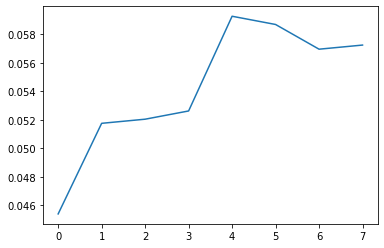

In [22]:
plt.plot(AllHitrate)   ###Max == 50

In [106]:
Vsvd_list = pureSVD(SVD_UserItemMAT,k=50)
print(len(Vsvd_list))

15


In [107]:
Vsvd_last = Vsvd_list[-1]
Vsvd_last

array([[-5.21093989e-03, -1.43997794e-03,  8.24085211e-04, ...,
        -8.84044305e-03, -7.85443608e-03, -4.24750457e-03],
       [-2.31463216e-01, -3.18206357e-02, -4.90215540e-02, ...,
         6.41414572e-02,  5.63991071e-02, -9.01850235e-02],
       [ 1.38939582e-02,  1.48931262e-02,  1.71452752e-03, ...,
         6.33829077e-03,  4.59954168e-03, -1.85764305e-02],
       ...,
       [ 1.15398630e-05, -1.10198082e-04, -4.03091186e-05, ...,
        -7.91126412e-07,  2.37334984e-05, -6.28646908e-06],
       [ 1.15398630e-05, -1.10198082e-04, -4.03091186e-05, ...,
        -7.91126412e-07,  2.37334984e-05, -6.28646908e-06],
       [ 1.15398630e-05, -1.10198082e-04, -4.03091186e-05, ...,
        -7.91126412e-07,  2.37334984e-05, -6.28646908e-06]])

### SVDAll Pred

In [108]:
AllUsersSVD_PRED =  TQDMgetALLTopNPred_ALLUSERS(SVD_UserItemMAT,Vsvd_list, N=10) 
print(len(AllUsersSVD_PRED))
AllUsersSVD_PRED[:2]

15it [07:33, 30.24s/it]15



[array([[   17,   108,  1072, ...,  1108,    89,  1215],
        [  663,  1062,   969, ...,   267,   719,  1107],
        [ 1300,   108,    90, ...,    50,   318,   678],
        ...,
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719]]),
 array([[   17,   108,  1072, ...,  1108,    89,  1215],
        [  663,  1062,   969, ...,   267,   719,  1107],
        [ 1300,   108,    90, ...,    50,   318,   213],
        ...,
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719]])]

In [109]:
with open('MLDF20M_SVD_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersSVD_PRED, f)


## iALS

### ALS_Tuning

In [ ]:
# newAMZB_DF = pd.read_csv("/mnt/bulky/oolaleke/TDM_Dataset/AMZB_afterUpdt.csv")
# print(newAMZB_DF.shape)
# print(newAMZB_DF['userId'].max(),newAMZB_DF['productId'].max())
# print(newAMZB_DF['userId'].nunique(),newAMZB_DF['productId'].nunique())
# print()
# print(newAMZB_DF['Updated_UserID'].max(),newAMZB_DF['Updated_ItemID'].max())
# print(newAMZB_DF['Updated_UserID'].nunique(),newAMZB_DF['Updated_ItemID'].nunique())
# newAMZB_DF.head()

In [110]:
rows_i = newMLDF_20M['Updated_UserID'].nunique()
cols_i = newMLDF_20M['Updated_ItemID'].nunique()
Rating_matrix = SingleRatingMatrix(newUserItem_list[0],'Updated_UserID','Updated_ItemID',rows_i,cols_i)  #changes start within steps...
Rating_matrix

<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
	with 8865107 stored elements in Compressed Sparse Row format>

In [111]:
als_params = dict(alpha = [ 0.001,0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
                  regularization = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10],
                  rank = list(range(10, 81, 10)),
                  iter_array = [10,15,20,25,30])

als_param_grid, als_param_names = random_grid(als_params, n=30)
print(als_param_names)
len(als_param_grid)                 

('alpha', 'regularization', 'rank', 'iter_array')


30

In [112]:
for i in range(10):
    alpha, reg, rank, iter = list(als_param_grid)[i]  
    print(alpha, reg, rank,iter)

100 0.01 10 30
0.1 0.5 50 25
0.5 0.005 70 10
0.1 0.05 60 25
1 0.001 70 10
0.05 0.1 60 30
50 0.005 60 15
0.1 0.1 80 10
0.001 0.001 30 10
1 0.01 30 15


In [113]:
train_set ,test_set,valid_set = TrainTest(Rating_matrix, pct_mask=0.2)
train_set

<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
	with 7092085 stored elements in Compressed Sparse Row format>

In [114]:
test_set

<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
	with 8865107 stored elements in Compressed Sparse Row format>

In [115]:
len(valid_set)

119781

In [116]:
best_model_Info = tune_ALS(train_set,test_set,valid_set,als_param_grid)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [15:29<7:29:19, 929.65s/it]latent factors= 10 ,regularization = 0.01:, n_iter = 30, alpha = 100, AUC= 0.981234


  0%|          | 0/25 [00:00<?, ?it/s]

  7%|▋         | 2/30 [33:11<7:50:13, 1007.62s/it]latent factors= 50 ,regularization = 0.5:, n_iter = 25, alpha = 0.1, AUC= 0.882249


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 3/30 [52:05<7:59:15, 1065.01s/it]latent factors= 70 ,regularization = 0.005:, n_iter = 10, alpha = 0.5, AUC= 0.87876


  0%|          | 0/25 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [1:11:21<7:57:07, 1101.05s/it]latent factors= 60 ,regularization = 0.05:, n_iter = 25, alpha = 0.1, AUC= 0.869231


  0%|          | 0/10 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [1:30:06<7:42:20, 1109.61s/it]latent factors= 70 ,regularization = 0.001:, n_iter = 10, alpha = 1, AUC= 0.897181


  0%|          | 0/30 [00:00<?, ?it/s]

 20%|██        | 6/30 [1:49:54<7:34:30, 1136.28s/it]latent factors= 60 ,regularization = 0.1:, n_iter = 30, alpha = 0.05, AUC= 0.870689


  0%|          | 0/15 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [2:08:24<7:12:16, 1127.69s/it]latent factors= 60 ,regularization = 0.005:, n_iter = 15, alpha = 50, AUC= 0.973382


  0%|          | 0/10 [00:00<?, ?it/s]

 27%|██▋       | 8/30 [2:28:29<7:02:34, 1152.46s/it]latent factors= 80 ,regularization = 0.1:, n_iter = 10, alpha = 0.1, AUC= 0.840435


  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 9/30 [2:45:10<6:26:43, 1104.91s/it]latent factors= 30 ,regularization = 0.001:, n_iter = 10, alpha = 0.001, AUC= 0.893471


  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [3:02:01<5:58:42, 1076.12s/it]latent factors= 30 ,regularization = 0.01:, n_iter = 15, alpha = 1, AUC= 0.937063


  0%|          | 0/25 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [3:22:06<5:53:11, 1115.34s/it]latent factors= 80 ,regularization = 0.1:, n_iter = 25, alpha = 0.001, AUC= 0.926929


  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 12/30 [3:36:39<5:12:34, 1041.90s/it]latent factors= 10 ,regularization = 0.5:, n_iter = 10, alpha = 5, AUC= 0.968743


  0%|          | 0/25 [00:00<?, ?it/s]

 40%|████      | 12/30 [3:49:06<5:43:39, 1145.53s/it]


KeyboardInterrupt: 

In [121]:
best_rank= 10 
best_reg = 0.01 
best_iter = 30 
best_alpha = 100
best_auc= 0.981234

In [122]:
#best_rank, best_reg, best_iter,best_alpha,best_auc,best_model = best_model_Info
print('best_rank: ', best_rank)
print('best_reg:  ', best_reg)
print('best_iter: ', best_iter)
print('best_alpha: ', best_alpha)
print('best_auc:  ', best_auc)

best_rank:  10
best_reg:   0.01
best_iter:  30
best_alpha:  100
best_auc:   0.981234


###RatMat & Updt

In [123]:
rows_i = newMLDF_20M['Updated_UserID'].nunique()
cols_i = newMLDF_20M['Updated_ItemID'].nunique()
UserItem_RatMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
UserItem_RatMAT

[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8865107 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8945455 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9025842 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9106051 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9186201 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9266468 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9346597 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9426837 stored elements in Compres

In [124]:
nuser_list = []
nItem_list = []
for df in  newUserItem_list:
    nuser_list.append(df['Updated_UserID'].max()+1)
    nItem_list.append(df['Updated_ItemID'].max()+1)

nuser_list = [0] + nuser_list  
nItem_list = [0] + nItem_list  

print(nuser_list)
print(nItem_list) 

[0, 122397, 123313, 124424, 125346, 126345, 127271, 128218, 129237, 130492, 131633, 132813, 133828, 134780, 135653, 136677]
[0, 15298, 15601, 15879, 16183, 16532, 16862, 17224, 17569, 17957, 18382, 18826, 19226, 19703, 20238, 20720]


In [125]:
## latent factors= 10 ,regularization = 0.01:, n_iter = 30, alpha = 100,
Ulist_als,Vlist_als = alternating_least_squares_cg(UserItem_RatMAT[-1],nuser_list,nItem_list,factors=10,alpha=100,reglr=0.01,iter=30)
print(len(Ulist_als))  
Ulist_als[:2]

15it [3:42:41, 890.79s/it]15



[array([[  5.28960945,  -3.47666675, -11.35418894, ..., -13.44966809,
          -0.12086596,   9.11610477],
        [ 10.47963892,  -2.29918768,  -4.82125089, ...,  -6.64665462,
          -6.11842063,   5.03027435],
        [  6.067721  ,  -1.11676687,  -4.3791496 , ..., -11.69010428,
         -11.42126117,   5.41734081],
        ...,
        [  8.92934911,  -2.93698352,  -2.07587963, ...,  -8.60711546,
           2.9300254 ,  -5.07105461],
        [  5.41032867,   0.5365421 ,  -6.76302212, ..., -10.53108666,
           5.12894852,  -4.94637789],
        [ 14.26189166,   3.68644619,   3.00248255, ..., -17.80604756,
           4.09919732,  -2.77420875]]),
 array([[  5.28960945,  -3.47666675, -11.35418894, ..., -13.44966809,
          -0.12086596,   9.11610477],
        [ 10.47963892,  -2.29918768,  -4.82125089, ...,  -6.64665462,
          -6.11842063,   5.03027435],
        [  6.067721  ,  -1.11676687,  -4.3791496 , ..., -11.69010428,
         -11.42126117,   5.41734081],
        ...,


In [126]:
Ulist_als[0].shape

(136677, 10)

### ilsAll Pred

In [127]:
##All prediction:
All_alsPRED_List = ialsALLPred_ALLUSERS(UserItem_RatMAT,Ulist_als,Vlist_als,N=10)
print(len(All_alsPRED_List))
All_alsPRED_List[:2]

15


[array([[ 140,   17,  261, ...,  948,  151, 1215],
        [  78,  149,  105, ...,  138,   89,  191],
        [ 129,  124,  179, ...,  609,  205,   63],
        ...,
        [  78,  135,  149, ...,  105,   15,   58],
        [2630, 4750, 5632, ..., 4032, 4137,  861],
        [ 135, 1062,   14, ...,   20,  969, 1052]]),
 array([[ 140,   17,  261, ...,  948,  151, 1215],
        [  78,  149,  105, ...,  138,   89,  191],
        [ 129,  124,  179, ...,  609,  205,   63],
        ...,
        [  78,  135,  149, ...,  105,   15,   58],
        [2630, 4750, 5632, ..., 4032, 4137,  861],
        [ 135, 1062,   14, ...,   20,  969, 1052]])]

In [128]:
All_alsPRED_List[0].shape

(136677, 10)

In [129]:
with open('MLDF20M_iALS_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_alsPRED_List, f)


##  RandRec:Test

In [130]:
print(len(SVD_UserItemMAT),len(newHOLDOUT_LIST))

15 15


In [131]:
All_UsersRRecPred = get_ALLRandPred(SVD_UserItemMAT,'Updated_UserID',N=10)
All_UsersRRecPred[:2]  

100%|██████████| 15/15 [15:04<00:00, 60.33s/it]


[array([[10399,  9457, 10652, ..., 20293,  9969, 13074],
        [17381,  9187, 19470, ..., 14438,  6737,  1733],
        [ 1731,  9052,  7557, ..., 12049, 13872,  9385],
        ...,
        [ 6374,  1653,   274, ..., 11490,  2060, 19305],
        [17965,  1419, 12976, ...,  9405, 14280,  4617],
        [17993, 15722,  5623, ..., 10584,  5186, 20247]]),
 array([[ 7497, 10920, 17390, ...,  1635, 18499, 10468],
        [10507, 15677,  3154, ...,  3331, 16174,  4025],
        [ 5266, 14584,  6137, ..., 14818,  7548,  1695],
        ...,
        [18879,  6476,  5348, ...,  4450, 12138,  8014],
        [ 8858,  8683, 15085, ..., 19253,  4969,   121],
        [ 5690, 14254,   503, ..., 19807,  4225, 17752]])]

In [132]:
All_UsersRRecPred[1].shape

(136677, 10)

In [133]:
with open('MLDF20M_RRec_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_UsersRRecPred, f)


## Most Pop Rec

In [134]:
                      #getAll_MOSTPOP_Pred(DF_list,user_column,item_colum,Nusers,N
Nusers = newMLDF_20M['Updated_UserID'].nunique()
All_MostPOPRED_List =  getAll_MOSTPOP_Pred(new_PSIDFlist,'Updated_UserID','Updated_ItemID',Nusers,N=10)
All_MostPOPRED_List[:2]

[array([[13086,  2770,    78, ...,    92,  6760,  5632],
        [13086,  2770,    78, ...,    92,  6760,  5632],
        [13086,  2770,    78, ...,    92,  6760,  5632],
        ...,
        [13086,  2770,    78, ...,    92,  6760,  5632],
        [13086,  2770,    78, ...,    92,  6760,  5632],
        [13086,  2770,    78, ...,    92,  6760,  5632]]),
 array([[13086,  2770,    76, ...,  4750,  6760,  5632],
        [13086,  2770,    76, ...,  4750,  6760,  5632],
        [13086,  2770,    76, ...,  4750,  6760,  5632],
        ...,
        [13086,  2770,    76, ...,  4750,  6760,  5632],
        [13086,  2770,    76, ...,  4750,  6760,  5632],
        [13086,  2770,    76, ...,  4750,  6760,  5632]])]

In [135]:
All_MostPOPRED_List[1].shape

(136677, 10)

In [136]:
with open('MLDF20M_MPop_allPRED.pkl', 'wb') as f:
     pickle.dump(All_MostPOPRED_List, f)


## HitRate

### Updated PSI

In [137]:
Top_NPred = TopNPred(UserItem_Matupdt[0],newHOLDOUT_LIST[0],V_1,'Updated_UserID',10)
Top_NPred

array([[2560, 1072, 4744, ..., 3041,  829, 3815],
       [ 980, 2250, 4652, ..., 1624, 4061, 1911],
       [2180,  532, 9037, ...,  144, 1466, 1066],
       ...,
       [ 180,  179, 1923, ...,  352,  781,  869],
       [1109,  144, 1115, ..., 2501, 1460, 1630],
       [2469, 1460,  157, ..., 2340, 2630, 2502]])

In [138]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_UserID','Updated_ItemID')

Number of hits:  185
Total Num of users:  3459
Recommendation HitRate:  0.05348366579936398


0.05348366579936398

In [139]:
AllUpdt_pred =  TQDMgetALLTopNPred(UserItem_Matupdt,newHOLDOUT_LIST,Vpsi_listUpdt,'Updated_UserID',N = 10)
print(len(AllUpdt_pred))
AllUpdt_pred[:2]

15it [00:11,  1.31it/s]15



[array([[2560, 1072, 4744, ..., 3041,  829, 3815],
        [ 980, 2250, 4652, ..., 1624, 4061, 1911],
        [2180,  532, 9037, ...,  144, 1466, 1066],
        ...,
        [ 180,  179, 1923, ...,  352,  781,  869],
        [1109,  144, 1115, ..., 2501, 1460, 1630],
        [2469, 1460,  157, ..., 2340, 2630, 2502]]),
 array([[2560, 1072, 4744, ..., 3041, 9331, 8837],
        [ 980, 2250, 4652, ..., 1624, 4061, 1911],
        [1300,  603, 1086, ..., 2560,  267,  663],
        ...,
        [2707,  969, 1763, ..., 1319, 4724, 2008],
        [1829, 1055, 2770, ..., 1070, 1807, 4080],
        [4724, 8837, 8928, ..., 8958, 4032, 9331]])]

In [140]:
AllSteps_HitR_updt, LowerBand_updt, Avg_HitR_updt, UpperBand_updt   = getAll_HitRate(newHOLDOUT_LIST,AllUpdt_pred,'Updated_UserID','Updated_ItemID')
AllSteps_HitR_updt

Number of hits:  185
Total Num of users:  3459
Recommendation HitRate:  0.05348366579936398
Number of hits:  160
Total Num of users:  3311
Recommendation HitRate:  0.048323769254001815
Number of hits:  163
Total Num of users:  3124
Recommendation HitRate:  0.052176696542893725
Number of hits:  160
Total Num of users:  3115
Recommendation HitRate:  0.051364365971107544
Number of hits:  173
Total Num of users:  3165
Recommendation HitRate:  0.05466034755134281
Number of hits:  154
Total Num of users:  3098
Recommendation HitRate:  0.04970948999354422
Number of hits:  136
Total Num of users:  3169
Recommendation HitRate:  0.04291574629220574
Number of hits:  168
Total Num of users:  3129
Recommendation HitRate:  0.053691275167785234
Number of hits:  186
Total Num of users:  3192
Recommendation HitRate:  0.05827067669172932
Number of hits:  183
Total Num of users:  3409
Recommendation HitRate:  0.05368143150484013
Number of hits:  182
Total Num of users:  3267
Recommendation HitRate:  0.05

[0.05348366579936398,
 0.048323769254001815,
 0.052176696542893725,
 0.051364365971107544,
 0.05466034755134281,
 0.04970948999354422,
 0.04291574629220574,
 0.053691275167785234,
 0.05827067669172932,
 0.05368143150484013,
 0.05570860116314662,
 0.05037374065648359,
 0.05952380952380952,
 0.05370650529500756,
 0.05860805860805861]

In [141]:
print(LowerBand_updt)
print(UpperBand_updt)
print(Avg_HitR_updt)

0.05070211425418469
0.05545764308119137
0.05307987866768803


### Regular PSI

In [142]:
Top10Pred_psi = TopNPred(UserItemMAT_regPSI[0], newHOLDOUT_LIST[0],Vpsi_listReg[0],'Updated_UserID',N=10)
print(Top10Pred_psi.shape)

(3459, 10)


In [143]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_UserID','Updated_ItemID')

Number of hits:  183
Total Num of users:  3459
Recommendation HitRate:  0.05290546400693842


0.05290546400693842

In [144]:
All_regPSI_PRED =  TQDMgetALLTopNPred(UserItemMAT_regPSI,newHOLDOUT_LIST,Vpsi_listReg,'Updated_UserID',N = 10)
print(len(All_regPSI_PRED))
All_regPSI_PRED[:2]

15it [00:10,  1.42it/s]15



[array([[2560, 1072, 4744, ..., 3041,  829, 3815],
        [ 980, 2250, 4652, ..., 1624, 4061, 1911],
        [2180,  532, 9037, ...,  144, 1466, 1066],
        ...,
        [ 180,  179, 1923, ...,  352,  781,  869],
        [1109,  144, 1115, ..., 2501, 1460, 1630],
        [2469, 1460,  157, ..., 2340, 2630, 2502]]),
 array([[2560, 1072, 4744, ..., 3041, 9331, 8837],
        [ 980, 2250, 4652, ..., 1624, 4061, 1911],
        [1300,  603, 1086, ..., 2560,  267,  663],
        ...,
        [2707,  969, 1763, ..., 1319, 4724, 2008],
        [1829, 1055, 2770, ..., 1070, 4080, 1807],
        [4724, 8837, 8928, ..., 8958, 4032, 4652]])]

In [145]:
AllSteps_Hitrate_psi, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_UserID','Updated_ItemID')
AllSteps_Hitrate_psi

Number of hits:  183
Total Num of users:  3459
Recommendation HitRate:  0.05290546400693842
Number of hits:  160
Total Num of users:  3311
Recommendation HitRate:  0.048323769254001815
Number of hits:  163
Total Num of users:  3124
Recommendation HitRate:  0.052176696542893725
Number of hits:  164
Total Num of users:  3115
Recommendation HitRate:  0.05264847512038523
Number of hits:  173
Total Num of users:  3165
Recommendation HitRate:  0.05466034755134281
Number of hits:  152
Total Num of users:  3098
Recommendation HitRate:  0.04906391220142027
Number of hits:  140
Total Num of users:  3169
Recommendation HitRate:  0.044177974124329444
Number of hits:  167
Total Num of users:  3129
Recommendation HitRate:  0.05337168424416747
Number of hits:  187
Total Num of users:  3192
Recommendation HitRate:  0.05858395989974937
Number of hits:  182
Total Num of users:  3409
Recommendation HitRate:  0.053388090349075976
Number of hits:  181
Total Num of users:  3267
Recommendation HitRate:  0.05

[0.05290546400693842,
 0.048323769254001815,
 0.052176696542893725,
 0.05264847512038523,
 0.05466034755134281,
 0.04906391220142027,
 0.044177974124329444,
 0.05337168424416747,
 0.05858395989974937,
 0.053388090349075976,
 0.055402509947964494,
 0.05004874878128047,
 0.05988455988455989,
 0.054084720121028745,
 0.05934065934065934]

In [146]:
print(LowerBand, Avg_HitRate, UpperBand)

0.05085060616484444 0.053204104757986495 0.05555760335112855


### SVD HItR_

In [147]:
Top10Pred_SVD = TopNPred(SVD_UserItemMAT[0],newHOLDOUT_LIST[0],Vsvd_list[0],'Updated_UserID',N=10)
print(Top10Pred_SVD.shape)
Top10Pred_SVD

(3459, 10)


array([[4744, 2560, 1072, ..., 1069, 1070,  829],
       [ 980, 4652, 2250, ..., 4061, 1624, 1911],
       [2180,  532, 6381, ..., 1466, 3407,    1],
       ...,
       [ 180,  352,  179, ..., 1909,  969, 1917],
       [ 144, 1109, 1115, ..., 2542, 2501,  198],
       [2469, 1460,  157, ..., 2340, 2630, 2502]])

In [148]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_UserID','Updated_ItemID')

Number of hits:  205
Total Num of users:  3459
Recommendation HitRate:  0.059265683723619546


0.059265683723619546

In [149]:
AllSVD_topNPRED =  TQDMgetALLTopNPred(SVD_UserItemMAT,newHOLDOUT_LIST,Vsvd_list,'Updated_UserID',N = 10)
print(len(AllSVD_topNPRED))
AllSVD_topNPRED[:2]

15it [00:10,  1.44it/s]15



[array([[4744, 2560, 1072, ..., 1069, 1070,  829],
        [ 980, 4652, 2250, ..., 4061, 1624, 1911],
        [2180,  532, 6381, ..., 1466, 3407,    1],
        ...,
        [ 180,  352,  179, ..., 1909,  969, 1917],
        [ 144, 1109, 1115, ..., 2542, 2501,  198],
        [2469, 1460,  157, ..., 2340, 2630, 2502]]),
 array([[ 4744,  1072,  2560, ...,  9331,  1069,  8837],
        [  980,  4652,  2250, ...,  4061,  1624,  1911],
        [ 1300,  1086,   603, ...,   267,   663,  3220],
        ...,
        [ 2707,   969,  1763, ...,  2543,  1319,  1126],
        [ 1829,  1055,  2770, ...,  1070,  4080,    59],
        [ 4724,  9761,  8837, ...,  9695, 11965,  8958]])]

In [150]:
AllSteps_Hitrate_svd, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_UserID','Updated_ItemID')

Number of hits:  205
Total Num of users:  3459
Recommendation HitRate:  0.059265683723619546
Number of hits:  165
Total Num of users:  3311
Recommendation HitRate:  0.04983388704318937
Number of hits:  169
Total Num of users:  3124
Recommendation HitRate:  0.05409731113956466
Number of hits:  182
Total Num of users:  3115
Recommendation HitRate:  0.058426966292134834
Number of hits:  182
Total Num of users:  3165
Recommendation HitRate:  0.05750394944707741
Number of hits:  154
Total Num of users:  3098
Recommendation HitRate:  0.04970948999354422
Number of hits:  147
Total Num of users:  3169
Recommendation HitRate:  0.04638687283054591
Number of hits:  180
Total Num of users:  3129
Recommendation HitRate:  0.05752636625119847
Number of hits:  195
Total Num of users:  3192
Recommendation HitRate:  0.06109022556390977
Number of hits:  187
Total Num of users:  3409
Recommendation HitRate:  0.054854796127896746
Number of hits:  198
Total Num of users:  3267
Recommendation HitRate:  0.060

In [151]:
AllSteps_Hitrate_svd

[0.059265683723619546,
 0.04983388704318937,
 0.05409731113956466,
 0.058426966292134834,
 0.05750394944707741,
 0.04970948999354422,
 0.04638687283054591,
 0.05752636625119847,
 0.06109022556390977,
 0.054854796127896746,
 0.06060606060606061,
 0.052973675658108545,
 0.06673881673881674,
 0.05937972768532526,
 0.06263736263736264]

In [152]:
 print(LowerBand, Avg_HitRate, UpperBand) 

0.05372014044420813 0.05673541278255698 0.05975068512090584


### RRec HitR_

### MPop HitR_

In [153]:
RRec_AllStepsHitR, RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR = getAll_RandomHitRate(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')

Number of hits:  1
Total Num of users:  3459
Recommendation HitRate:  0.0002891008962127783
Number of hits:  2
Total Num of users:  3311
Recommendation HitRate:  0.0006040471156750226
Number of hits:  2
Total Num of users:  3124
Recommendation HitRate:  0.0006402048655569782
Number of hits:  0
Total Num of users:  3115
Recommendation HitRate:  0.0
Number of hits:  1
Total Num of users:  3165
Recommendation HitRate:  0.000315955766192733
Number of hits:  2
Total Num of users:  3098
Recommendation HitRate:  0.0006455777921239509
Number of hits:  4
Total Num of users:  3169
Recommendation HitRate:  0.0012622278321236984
Number of hits:  1
Total Num of users:  3129
Recommendation HitRate:  0.00031959092361776926
Number of hits:  2
Total Num of users:  3192
Recommendation HitRate:  0.0006265664160401002
Number of hits:  3
Total Num of users:  3409
Recommendation HitRate:  0.0008800234672924611
Number of hits:  0
Total Num of users:  3267
Recommendation HitRate:  0.0
Number of hits:  1
Total

In [154]:
RRec_AllStepsHitR

[0.0002891008962127783,
 0.0006040471156750226,
 0.0006402048655569782,
 0.0,
 0.000315955766192733,
 0.0006455777921239509,
 0.0012622278321236984,
 0.00031959092361776926,
 0.0006265664160401002,
 0.0008800234672924611,
 0.0,
 0.00032499187520311994,
 0.00036075036075036075,
 0.0007564296520423601,
 0.001098901098901099]

In [155]:
print( RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR)

0.000340182505375665 0.0005416245374488288 0.0007430665695219926


In [ ]:
##MOSTPOP

In [156]:
AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand  = getAll_MostPOPHitRate(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')

Number of hits:  98
Total Num of users:  3459
Recommendation HitRate:  0.028331887828852268
Number of hits:  68
Total Num of users:  3311
Recommendation HitRate:  0.02053760193295077
Number of hits:  70
Total Num of users:  3124
Recommendation HitRate:  0.02240717029449424
Number of hits:  105
Total Num of users:  3115
Recommendation HitRate:  0.033707865168539325
Number of hits:  157
Total Num of users:  3165
Recommendation HitRate:  0.04960505529225909
Number of hits:  144
Total Num of users:  3098
Recommendation HitRate:  0.046481601032924466
Number of hits:  158
Total Num of users:  3169
Recommendation HitRate:  0.04985799936888608
Number of hits:  106
Total Num of users:  3129
Recommendation HitRate:  0.03387663790348354
Number of hits:  108
Total Num of users:  3192
Recommendation HitRate:  0.03383458646616541
Number of hits:  164
Total Num of users:  3409
Recommendation HitRate:  0.04810794954532121
Number of hits:  114
Total Num of users:  3267
Recommendation HitRate:  0.034894

In [157]:
AllSteps_Hitrate

[0.028331887828852268,
 0.02053760193295077,
 0.02240717029449424,
 0.033707865168539325,
 0.04960505529225909,
 0.046481601032924466,
 0.04985799936888608,
 0.03387663790348354,
 0.03383458646616541,
 0.04810794954532121,
 0.03489439853076217,
 0.03899902502437439,
 0.027056277056277056,
 0.044251134644478066,
 0.041758241758241756]

In [158]:
print(LowerBand, Avg_HitRate, UpperBand)

0.03155772898046011 0.03691382878986733 0.042269928599274545


### iALS HitR_

In [159]:
##Hitrate
top10_pred = ials_TopNPred(UserItem_RatMAT[0],newHOLDOUT_LIST[0],Ulist_als[0],Vlist_als[0],'Updated_UserID', N=10)
print(top10_pred.shape)
top10_pred

(3459, 10)


array([[18096, 16481, 18113, ...,  9142, 19018,  1397],
       [  914,   286,   406, ..., 11192,  2063,  2996],
       [  146,  1310,   228, ...,  3381,  7800,  5624],
       ...,
       [ 1062,   135,   969, ...,  1003,    20,   980],
       [ 1624,  2630,  2560, ...,  2167,  2378,  2250],
       [ 2547,  2347,  2235, ...,  1582,  2931,  3070]])

In [161]:
Hitrate_Eval(newHOLDOUT_LIST[0],top10_pred,'Updated_UserID','Updated_ItemID')  #

Number of hits:  144
Total Num of users:  3459
Recommendation HitRate:  0.04163052905464007


0.04163052905464007

In [162]:
                #ials_getALLPredTQDM(RatingMat_List,HOLDOUT_list,U_list,V_list,user_column,N)
Allals_topNPRED =  ials_getALLPredTQDM(UserItem_RatMAT,newHOLDOUT_LIST,Ulist_als,Vlist_als,'Updated_UserID',N = 10)
print(len(Allals_topNPRED))
Allals_topNPRED[:2]

15it [00:09,  1.55it/s]15



[array([[18096, 16481, 18113, ...,  9142, 19018,  1397],
        [  914,   286,   406, ..., 11192,  2063,  2996],
        [  146,  1310,   228, ...,  3381,  7800,  5624],
        ...,
        [ 1062,   135,   969, ...,  1003,    20,   980],
        [ 1624,  2630,  2560, ...,  2167,  2378,  2250],
        [ 2547,  2347,  2235, ...,  1582,  2931,  3070]]),
 array([[18096, 16481, 18113, ...,  9142, 19018,  1397],
        [  914,   286,   406, ..., 11192,  2063,  2996],
        [  195,   137,  2347, ...,    62,   199,  2925],
        ...,
        [  825,   797,   779, ...,  1061,  1745,  1129],
        [ 1053,   800,   980, ...,  1048,  1052,  1072],
        [ 4724,  8837,  6760, ...,  9761,  8695,  5632]])]

In [163]:
als_AllStepsHitR_, als_LBand, als_AvgHitR, als_UBand   = getAll_HitRate(newHOLDOUT_LIST,Allals_topNPRED,'Updated_UserID','Updated_ItemID')
als_AllStepsHitR_

Number of hits:  144
Total Num of users:  3459
Recommendation HitRate:  0.04163052905464007
Number of hits:  136
Total Num of users:  3311
Recommendation HitRate:  0.04107520386590154
Number of hits:  120
Total Num of users:  3124
Recommendation HitRate:  0.03841229193341869
Number of hits:  120
Total Num of users:  3115
Recommendation HitRate:  0.038523274478330656
Number of hits:  124
Total Num of users:  3165
Recommendation HitRate:  0.039178515007898894
Number of hits:  100
Total Num of users:  3098
Recommendation HitRate:  0.03227888960619755
Number of hits:  105
Total Num of users:  3169
Recommendation HitRate:  0.03313348059324708
Number of hits:  127
Total Num of users:  3129
Recommendation HitRate:  0.0405880472994567
Number of hits:  122
Total Num of users:  3192
Recommendation HitRate:  0.03822055137844611
Number of hits:  146
Total Num of users:  3409
Recommendation HitRate:  0.04282780874156644
Number of hits:  120
Total Num of users:  3267
Recommendation HitRate:  0.03673

[0.04163052905464007,
 0.04107520386590154,
 0.03841229193341869,
 0.038523274478330656,
 0.039178515007898894,
 0.03227888960619755,
 0.03313348059324708,
 0.0405880472994567,
 0.03822055137844611,
 0.04282780874156644,
 0.03673094582185491,
 0.03802404939876503,
 0.04040404040404041,
 0.03328290468986384,
 0.028205128205128206]

In [165]:
print( als_LBand, als_AvgHitR, als_UBand)

0.03524289624938684 0.03750104403191708 0.039759191814447314


## MRR_Scores

### Updated_mrr

In [166]:
mrr_1st = MRR_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_ItemID')
print("1st Step MRR: ",mrr_1st)

1st Step MRR:  0.01975006539186938


In [167]:
AllSteps_MRRUpdt, LowerB_Updt, AvgMRR_Updt, UpperB_Updt  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllUpdt_pred,'Updated_ItemID')
AllSteps_MRRUpdt    

15it [00:00, 570.76it/s]


[0.01975,
 0.019939,
 0.020556,
 0.023973,
 0.022273,
 0.018741,
 0.015228,
 0.020376,
 0.024525,
 0.020789,
 0.023081,
 0.019634,
 0.025079,
 0.021992,
 0.025983]

In [169]:
print(LowerB_Updt, AvgMRR_Updt, UpperB_Updt)
print("Average MRR: ",AvgMRR_Updt)

0.019908 0.021461 0.023014
Average MRR:  0.021461


### RegPSI_MRR

In [171]:
##MRR: 
mrr_psi_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_ItemID')
print("1st Step MRR: ",mrr_psi_1st)

1st Step MRR:  0.019661040671448304


In [172]:
psi_AllStepsMRR, psi_LowerB, psi_AvgMRR, psi_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_ItemID')
psi_AllStepsMRR  


15it [00:00, 585.94it/s]


[0.019661,
 0.019737,
 0.020506,
 0.024115,
 0.022424,
 0.018706,
 0.015411,
 0.020189,
 0.024576,
 0.020357,
 0.023035,
 0.019458,
 0.025305,
 0.021488,
 0.026158]

In [173]:
print(psi_LowerB, psi_AvgMRR, psi_UpperB)
print("Average MRR: ",psi_AvgMRR)

0.01982 0.021408 0.022996
Average MRR:  0.021408


### SVD_MRR

In [174]:
##MRR: 
mrr_SVD_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_ItemID')
print("1st Step MRR: ",mrr_SVD_1st)

1st Step MRR:  0.021891477030245462


In [175]:
svd_AllStepsMRR, svd_LowerB, svd_AvgMRR, svd_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_ItemID')
svd_AllStepsMRR  

15it [00:00, 593.52it/s]


[0.021891,
 0.020462,
 0.020787,
 0.026738,
 0.023202,
 0.019234,
 0.015943,
 0.020867,
 0.025518,
 0.02196,
 0.024627,
 0.020163,
 0.027391,
 0.023731,
 0.02687]

In [176]:
 print(svd_LowerB, svd_AvgMRR, svd_UpperB )

0.020838 0.022626 0.024413


### RRec_MRR

In [177]:
RRec_AllStepsMRR, RRec_LowB, RRec_Avg_MRR, RRec_UppB = getAll_RandomRecMRR(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')
RRec_AllStepsMRR

15it [00:00, 421.28it/s]


[2.9e-05,
 0.000136,
 0.000267,
 0,
 6.3e-05,
 0.000145,
 0.00051,
 5.3e-05,
 0.000107,
 0.000293,
 0,
 4.6e-05,
 3.6e-05,
 0.00018,
 0.000534]

In [178]:
print(RRec_LowB, RRec_Avg_MRR, RRec_UppB )

6.480499621493013e-05 0.00015993333333333334 0.00025506167045173656


### Mpop_MRR

In [179]:
#MRR....
                                    #getAll_MostPOP_MRR(HOLDOUT_list,All_MostPOPRED_List,user_column,item_column)
Mpop_AllStepsMRR, Mpop_LowB, Mpop_AvgMRR, Mpop_UppB = getAll_MostPOP_MRR(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')
Mpop_AllStepsMRR

15it [00:00, 408.52it/s]


[0.01098044209492605,
 0.008510112995162829,
 0.005915797817206269,
 0.01641162832174068,
 0.02132036911657765,
 0.012429934315021467,
 0.02729592731170516,
 0.009584937629041177,
 0.011028439153439156,
 0.010724296563252267,
 0.010729225880741034,
 0.008993634286126975,
 0.007528802766898005,
 0.0121273383281704,
 0.009541979184836328]

In [180]:
print( Mpop_LowB, Mpop_AvgMRR, Mpop_UppB )

0.0091206955312628 0.012208191050989697 0.015295686570716595


### IALS_MRR

In [181]:
##mrr
#als_AllStepsHitR_, als_LBand, als_AvgHitR, als_UBand 
als_AllStepsMRR, als_LBand, als_AvgMRR, als_UBand  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,Allals_topNPRED,'Updated_ItemID')
als_AllStepsMRR    

15it [00:00, 598.79it/s]


[0.017103,
 0.013691,
 0.013936,
 0.013442,
 0.011989,
 0.011103,
 0.011098,
 0.012904,
 0.013783,
 0.014778,
 0.013291,
 0.012516,
 0.015566,
 0.013148,
 0.009847]

In [182]:
print(als_LBand, als_AvgMRR, als_UBand )

0.012203 0.013213 0.014223


## Coverage

### UpdtedPSI_COV

In [185]:
StepCoverage_Ratio(newMLDF_20M,AllUsers_updtPRED[0],'Updated_ItemID')  

0.042278

In [187]:
UpdtAvg_Coverage_List = AllSteps_Coverage_Ratio(newMLDF_20M,AllUsers_updtPRED,'Updated_ItemID')
UpdtAvg_Coverage_List

[0.042278,
 0.042326,
 0.042278,
 0.042278,
 0.042133,
 0.042181,
 0.042471,
 0.042471,
 0.042519,
 0.042471,
 0.042471,
 0.041988,
 0.042085,
 0.042085,
 0.042181]

###RegPSI_COV

In [188]:
psi_AvgCoverage_List = AllSteps_Coverage_Ratio(newMLDF_20M,AllUsersRegPIS_PRED,'Updated_ItemID')
psi_AvgCoverage_List

[0.042326,
 0.042375,
 0.042326,
 0.042423,
 0.042568,
 0.042519,
 0.042664,
 0.042809,
 0.042761,
 0.042905,
 0.042857,
 0.043098,
 0.043243,
 0.04334,
 0.042905]

### SVD_COV


In [189]:
SVD_AvgCoverage_List = AllSteps_Coverage_Ratio(newMLDF_20M,AllUsersSVD_PRED,'Updated_ItemID')
SVD_AvgCoverage_List

[0.043292,
 0.043147,
 0.043243,
 0.043243,
 0.043678,
 0.043822,
 0.044112,
 0.044208,
 0.044112,
 0.044402,
 0.044788,
 0.045077,
 0.04527,
 0.04527,
 0.044643]

### RRec_COV

In [190]:
##COVERAGE
RRec_AvgCoverageList = AllSteps_Coverage_Ratio(newMLDF_20M,All_UsersRRecPred,'Updated_ItemID')
RRec_AvgCoverageList

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### Mpop_COV

In [191]:
##COVERAGE
MPop_AvgCoverageList = AllSteps_Coverage_Ratio(newMLDF_20M,All_MostPOPRED_List,'Updated_ItemID')
MPop_AvgCoverageList

[0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483]

### IALS_COV

In [192]:
###cOVERAGE:
als_AvgCovList = AllSteps_Coverage_Ratio(newMLDF_20M,All_alsPRED_List,'Updated_ItemID')
als_AvgCovList

[0.117712,
 0.117664,
 0.117712,
 0.117712,
 0.117712,
 0.117857,
 0.118002,
 0.118002,
 0.118098,
 0.118243,
 0.118243,
 0.11834,
 0.118726,
 0.11916,
 0.119208]

In [ ]:
## AllSVD Prediction

## CORRELATION Report


In [193]:
AllSteps = list(range(1,15))
print(len(AllSteps))
print(len(AllUsers_updtPRED))
AllSteps

14
15


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

####  Updated_Corr 

In [ ]:
#newHOLDOUT_LIST  newUserItem_list new_PSIDFlist newMLDF_1M

In [194]:
UpdtPSICorr_ = Updt_getAll_AvgCorr(AllUsers_updtPRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
UpdtPSICorr_

array([array([1.        , 1.        , 1.        , ..., 0.        , 0.5327588 ,
              0.92942099])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 0.88483146,
              0.93397092])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.37435993, 1.        ,
              0.22080715])                                                    ,
       array([1., 1., 1., ..., 0., 0., 0.]),
       array([1.        , 0.98788042, 1.        , ..., 0.14186262, 0.47797357,
              0.25762481])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.12326891, 0.97749498,
              0.        ])                                                    ,
       array([1.        , 0.99244163, 1.        , ..., 0.74656886, 0.97010543,
              0.42311771])                                                    ,
 

In [195]:
UpdtPSICorr_.shape
for df in UpdtPSICorr_:
    print(df.mean())  

0.9869968716072547
0.9868989972464394
0.9865945505051228
0.9867358455398915
0.9870913236773649
0.9873940193396127
0.9861379816431397
0.9847879831721422
0.9859487909279454
0.9857501791677638
0.9862889000073568
0.9861786579017224
0.9869899653239385
0.9867127416063536


#### RegPSI Corr_

In [196]:
RegPSICorr_ = Updt_getAll_AvgCorr(AllUsersRegPIS_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
RegPSICorr_

array([array([1.        , 1.        , 1.        , ..., 0.        , 0.5327588 ,
              0.92942099])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 0.88483146,
              0.99244163])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.37435993, 0.94467132,
              0.22080715])                                                    ,
       array([1.        , 0.99244163, 1.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.14933043, 0.47384185,
              0.25762481])                                                    ,
       array([1.        , 0.98788042, 1.        , ..., 0.12326891, 0.97749498,
              0.        ])                                                    ,
       array([1.        , 1.        , 1.      

In [197]:
RegPSICorr_.shape
for df in RegPSICorr_:
    print(df.mean())  

0.9855048062717018
0.9861018386404111
0.9852377038892418
0.9857303673077384
0.9862022524456981
0.9866724545432374
0.9854086006170346
0.9847044408034471
0.9852414145782077
0.9852197279323629
0.9858297502108592
0.9850812223405825
0.9861475520293389
0.9863765964344147


#### SVD Corr_

In [198]:
pureSVDCorr_ = Updt_getAll_AvgCorr(AllUsersSVD_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
pureSVDCorr_

array([array([1.        , 1.        , 0.9188873 , ..., 0.        , 0.52326901,
              0.9526455 ])                                                    ,
       array([1.        , 1.        , 0.94287971, ..., 0.96643133, 0.91739187,
              0.93397092])                                                    ,
       array([1.        , 1.        , 0.9188873 , ..., 0.40176621, 1.        ,
              0.26897619])                                                    ,
       array([0.88386932, 1.        , 1.        , ..., 0.        , 0.        ,
              0.01933435])                                                    ,
       array([1.        , 0.99056095, 0.82833787, ..., 0.12661223, 0.46768741,
              0.20792079])                                                    ,
       array([1.        , 1.        , 0.98788042, ..., 0.1898122 , 0.93473132,
              0.        ])                                                    ,
       array([1.        , 1.        , 0.966431

In [199]:
pureSVDCorr_.shape
for df in pureSVDCorr_:
    print(df.mean())  

0.9579424284625256
0.965364936075921
0.9642275983258505
0.9608110874077603
0.953990420958191
0.9599172349005631
0.9566948972961938
0.9513547931345175
0.9524740479592377
0.9549345307900835
0.9570971666956241
0.9560427963904784
0.9606629440666354
0.9639037143474501


### RRec_Corr 

In [200]:
RandRec_Corr = Updt_getAll_AvgCorr(All_UsersRRecPred,newUserItem_list,AllSteps,'Updated_UserID')  #,
RandRec_Corr

array([array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [201]:
RandRec_Corr.shape
for df in RandRec_Corr:
    print(df.mean())  

0.00014943053005383439
0.00014655634827379167
0.00016311911918226105
0.00015405213865251005
0.0001428826447486091
0.00015048594727601791
0.00015796929672729035
0.00015671588665702664
0.00014516019575147408
0.00016528054798944014
0.00015321439168188263
0.0001413929288347257
0.00014559461697162025
0.00014997510393781067


### Mpop_Corr 

In [202]:
MPop_Corr = Updt_getAll_AvgCorr(All_MostPOPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
MPop_Corr

array([array([0.88146826, 0.88146826, 0.88146826, ..., 0.88146826, 0.88146826,
              0.88146826])                                                    ,
       array([0.39435156, 0.39435156, 0.39435156, ..., 0.39435156, 0.39435156,
              0.39435156])                                                    ,
       array([0.47017229, 0.47017229, 0.47017229, ..., 0.47017229, 0.47017229,
              0.47017229])                                                    ,
       array([0.39382495, 0.39382495, 0.39382495, ..., 0.39382495, 0.39382495,
              0.39382495])                                                    ,
       array([0.44146079, 0.44146079, 0.44146079, ..., 0.44146079, 0.44146079,
              0.44146079])                                                    ,
       array([0.45095341, 0.45095341, 0.45095341, ..., 0.45095341, 0.45095341,
              0.45095341])                                                    ,
       array([0.43851101, 0.43851101, 0.438511

In [203]:
MPop_Corr.shape
for df in MPop_Corr:
    print(df.mean())  

0.8814682640836098
0.39435156323793324
0.4701722935962555
0.39382494570862053
0.44146079484425366
0.45095341065461
0.43851101149873295
0.6554895144106763
0.7634691195795007
0.700103650811931
0.7708733205374277
0.5519343986543311
0.4021656534954409
0.5709268915611362


### iALS_Corr 

In [204]:
iALSCorr_ = Updt_getAll_AvgCorr(All_alsPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
iALSCorr_

array([array([1.        , 1.        , 1.        , ..., 0.92690249, 1.        ,
              1.        ])                                                    ,
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([1.        , 1.        , 1.        , ..., 0.71951077, 0.80796081,
              0.09331951])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.32264134, 0.92690249,
              0.87216233])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.78048486, 1.        ,
              0.49096051])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.91813929, 1.        ,
              1.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 0.92690249,
              0.08321104])          

In [205]:
iALSCorr_.shape
for df in iALSCorr_:
    print(df.mean())  

0.9987567467120707
0.9991266579475448
0.9989145893222382
0.9989932732371845
0.99905141450639
0.9990424458960305
0.999147814037508
0.9992544468887866
0.9989828959987427
0.9990199918046216
0.9990891580278136
0.9988215829920856
0.9989475675329732
0.9992511952139278


## Multi VAE

###Functions

In [34]:
from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat

In [35]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [36]:
def init_weights(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.xavier_uniform_(param.data)
        elif "bias" in name:
            param.data.normal_(std=0.001)

def vae_loss_fn(inp, out, mu, logvar, anneal):
    neg_ll = -torch.mean(torch.sum(F.log_softmax(out, 1) * inp, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return neg_ll + anneal * KLD


def early_stopping(curr_value, best_value, stop_step, patience, score_fn):
    if (score_fn == "loss" and curr_value <= best_value) or (
        score_fn == "metric" and curr_value >= best_value):
        stop_step, best_value = 0, curr_value
    else:
        stop_step += 1
    if stop_step >= patience:
        print("Early stopping triggered. patience: {} log:{}".format(patience, best_value))
        stop = True
    else:
        stop = False
    return best_value, stop_step, stop      



In [37]:
class Encoder(nn.Module):
    def __init__(self, q_dims, dropout):  ## q_dims: List[int], dropout: List[float]
        super().__init__()

        self.q_dims = q_dims
        q_dims_ = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, q_dims_[:-1], q_dims_[1:])):
            self.q_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.q_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = F.normalize(X, p=2, dim=1)
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.tanh(h)
            else:
                mu, logvar = torch.split(h, self.q_dims[-1], dim=1)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, p_dims, dropout):  #p_dims: List[int], dropout: List[float]
        super().__init__()

        self.p_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, p_dims[:-1], p_dims[1:])):
            self.p_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.p_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = X
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.tanh(h)
        return h


class MultiVAE(nn.Module):
    def __init__(self,p_dims,q_dims,dropout_enc,dropout_dec): #p_dims:List[int],q_dims:List[int],dropout_enc:List[float],dropout_dec:List[float], 
        super().__init__()
        self.encode = Encoder(q_dims, dropout_enc)  #q_dims == Encoder dimensions
        self.decode = Decoder(p_dims, dropout_dec)  #p_dims == Decoder dimensions

    def forward(self, X):
        mu, logvar = self.encode(X)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sampled_z = mu + float(self.training) * eps * std
        return self.decode(sampled_z), mu, logvar        



#Recall = (Relevant_Items_Recommended in top-k)/(Relevant_Items)



### Data Import

In [12]:
#MOVIElen_20M
newMLDF_20M = pd.read_csv('/home/oolaleke/incremental_PSI/Notebooks/MLDF20M_afterUpdt.csv.zip')
newMLDF_20M['timestamp'] = pd.to_datetime(newMLDF_20M['timestamp']) 
print(newMLDF_20M.shape)   #userId_int
print(newMLDF_20M.dtypes)
newMLDF_20M.head()

(9990682, 9)
userid                     int64
movieId                    int64
rating                     int64
timestamp         datetime64[ns]
timestamp_YM              object
userId                     int64
productId                  int64
Updated_UserID             int64
Updated_ItemID             int64
dtype: object


,userid,movieId,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
0,28507,1176,1,1995-01-09 11:46:44,1995-01,0,0,0,0
1,131160,47,1,1995-01-09 11:46:49,1995-01,1,1,1,1
2,85252,70,1,1996-01-29 00:00:00,1996-01,2,2,2,2
3,134445,45,1,1996-01-29 00:00:00,1996-01,3,3,3,3
4,99851,10,1,1996-01-29 00:00:00,1996-01,4,4,4,4


In [13]:
newMLDF_20M['Updated_UserID'].nunique()

136677

In [14]:
raw_data = newMLDF_20M
user_activity =   raw_data['Updated_UserID'].unique()
item_popularity = raw_data['Updated_ItemID'].unique()
print(user_activity.shape)
print(item_popularity.shape)
print()
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

(136677,)
(20720,)

After filtering, there are 9990682 watching events from 136677 users and 20720 movies (sparsity: 0.353%)


In [15]:
unique_uid = user_activity
train_users, valid_users, test_users = split_users(raw_data,'Updated_UserID',n_heldout_users=10000)
print(train_users.shape)
train_users

(116677,)


array([104323,  11053, 111295, ..., 110461,  35852, 136618])

In [16]:
print(valid_users.shape)
#valid_users

(10000,)


In [17]:
print(test_users.shape)
#test_users

(10000,)


In [18]:
##train data observation...
train_df = raw_data.loc[raw_data['Updated_UserID'].isin(train_users)]
print(train_df['Updated_UserID'].nunique())
train_df.sample(10)

116677


,userid,movieId,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
852947,83071,376,1,1997-02-08 14:52:45,1997-02,27273,112,27273,112
716480,98098,62,1,1996-12-02 12:22:35,1996-12,23782,27,23782,27
4194814,60666,1734,1,2002-11-07 13:19:05,2002-11,69308,1658,69308,1658
9232925,25367,296,1,2012-12-16 17:06:50,2012-12,126873,76,126873,76
4901622,38205,3510,1,2004-03-20 13:13:52,2004-03,76428,3373,76428,3373
3241519,11747,3967,1,2001-02-12 04:02:33,2001-02,57243,3758,57243,3758
2897122,10190,1210,1,2000-11-20 00:52:14,2000-11,55679,1062,55679,1062
6949263,75879,1198,1,2007-09-21 21:46:54,2007-09,98731,1048,98731,1048
9890013,135828,175,1,2015-01-22 05:46:15,2015-01,135432,248,135432,248
5465198,98603,5971,1,2005-03-22 07:51:15,2005-03,82256,5639,82256,5639


In [33]:
### items used in the training data...
train_Items = pd.unique(train_df['Updated_ItemID']) 
print(len(train_Items))
train_Items

20161


array([    0,     1,     2, ..., 20509, 20510, 20511])

In [20]:
# Save index dictionaries to "numerise" later one
unique_uid = user_activity
item2id = dict((sid, i) for (i, sid) in enumerate(train_Items))
user2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))
print(len(item2id))
print(len(user2id))

20161
136677


In [21]:
          #for validation and test they consider "only" items that have been seen during training
valid_df = raw_data[raw_data["Updated_UserID"].isin(valid_users)& raw_data["Updated_ItemID"].isin(train_Items)]  #vd_obsrv 
test_df = raw_data[raw_data["Updated_UserID"].isin(test_users) & raw_data["Updated_ItemID"].isin(train_Items)]  #te_obsr
print("Validation Set")
print(valid_df['Updated_UserID'].nunique())
print(valid_df.shape)
print()
print("Test Set")
print(test_df['Updated_UserID'].nunique())
print(test_df.shape)


Validation Set
10000
(747800, 9)

Test Set
10000
(731563, 9)


In [22]:
valid_trn, valid_tst = split_train_test(valid_df, test_prop=0.2)
print(valid_trn.shape, valid_tst.shape) 

0 users sampled
250 users sampled
500 users sampled
750 users sampled
1000 users sampled
1250 users sampled
1500 users sampled
1750 users sampled
2000 users sampled
2250 users sampled
2500 users sampled
2750 users sampled
3000 users sampled
3250 users sampled
3500 users sampled
3750 users sampled
4000 users sampled
4250 users sampled
4500 users sampled
4750 users sampled
5000 users sampled
5250 users sampled
5500 users sampled
5750 users sampled
6000 users sampled
6250 users sampled
6500 users sampled
6750 users sampled
7000 users sampled
7250 users sampled
7500 users sampled
7750 users sampled
8000 users sampled
8250 users sampled
8500 users sampled
8750 users sampled
9000 users sampled
9250 users sampled
9500 users sampled
9750 users sampled
(602214, 9) (145586, 9)


In [23]:
test_train, test_tst = split_train_test(test_df, test_prop=0.2)
print(test_train.shape, test_tst.shape)   ##

0 users sampled
250 users sampled
500 users sampled
750 users sampled
1000 users sampled
1250 users sampled
1500 users sampled
1750 users sampled
2000 users sampled
2250 users sampled
2500 users sampled
2750 users sampled
3000 users sampled
3250 users sampled
3500 users sampled
3750 users sampled
4000 users sampled
4250 users sampled
4500 users sampled
4750 users sampled
5000 users sampled
5250 users sampled
5500 users sampled
5750 users sampled
6000 users sampled
6250 users sampled
6500 users sampled
6750 users sampled
7000 users sampled
7250 users sampled
7500 users sampled
7750 users sampled
8000 users sampled
8250 users sampled
8500 users sampled
8750 users sampled
9000 users sampled
9250 users sampled
9500 users sampled
9750 users sampled
(589240, 9) (142323, 9)


In [24]:
Train_DF   =    numerize_data(train_df,user2id,item2id, 'Updated_UserID','Updated_ItemID')
ValidTrain_DF = numerize_data(valid_trn,user2id,item2id,'Updated_UserID','Updated_ItemID')
ValidTest_DF = numerize_data(valid_tst,user2id,item2id, 'Updated_UserID','Updated_ItemID')
TestTrain_DF = numerize_data(test_train,user2id,item2id,'Updated_UserID','Updated_ItemID')
TestTest_DF =  numerize_data(test_tst,user2id,item2id, 'Updated_UserID','Updated_ItemID')

print("Training Data: ",Train_DF.shape)
print()
print("Validaion DF: ", ValidTrain_DF.shape,ValidTest_DF.shape)
print("Test DF:      ", TestTrain_DF.shape,TestTest_DF.shape)

Training Data:  (8510699, 2)

Validaion DF:  (602214, 2) (145586, 2)
Test DF:       (589240, 2) (142323, 2)


In [25]:
n_items = len(train_Items)                            #train_Items = unique_sid
TrainDF_RatMat = get_TrainRatMat(Train_DF,'Updated_UserID','Updated_ItemID',n_items)
ValidTrain_RatMat, ValidTest_RatMat = getTrainTest_RatMat(ValidTrain_DF, ValidTest_DF,'Updated_UserID','Updated_ItemID',n_items)
TestTrain_RatMat, TestTest_RatMat = getTrainTest_RatMat(TestTrain_DF, TestTest_DF,'Updated_UserID','Updated_ItemID',n_items)

TrainDF_RatMat

<136677x20161 sparse matrix of type '<class 'numpy.float64'>'
	with 8510699 stored elements in Compressed Sparse Row format>

In [32]:
ValidTrain_RatMat

<136671x20161 sparse matrix of type '<class 'numpy.float64'>'
	with 602214 stored elements in Compressed Sparse Row format>

In [1]:
def train_step(model, optimizer, data, epoch):
    model.train()
    running_loss = 0.0
    global update_count
    N = data.shape[0]
    idxlist = list(range(N))
    np.random.shuffle(idxlist)
    training_steps = len(range(0, N, batch_size))   #training_steps
    for batch_idx, start_idx in zip(range(training_steps), range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        X_inp = data[idxlist[start_idx:end_idx]]
        X_inp = torch.FloatTensor(X_inp.toarray()).to(device)
        if constant_anneal:
            anneal = anneal_cap
        else:
            anneal = min(anneal_cap, update_count / total_anneal_steps)
        update_count += 1
        optimizer.zero_grad()
        X_out, mu, logvar = model(X_inp)
        loss = vae_loss_fn(X_inp, X_out, mu, logvar, anneal)
        train_step.anneal = anneal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        avg_loss = running_loss / (batch_idx + 1)
        #t.set_postfix(loss=avg_loss)


def eval_step(model,data_tr,data_te):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, r20_list, r50_list = [], [], []
    #with trange(eval_steps) as t:
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_te = data_te[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)

             X_out, mu, logvar = model(X_tr_inp)
             loss = vae_loss_fn(X_tr_inp, X_out, mu, logvar, train_step.anneal)
             running_loss += loss.item()
             avg_loss = running_loss / (batch_idx + 1)

             #Exclude examples from training set
             X_out = X_out.cpu().numpy()
             X_out[X_tr.nonzero()] = -np.inf

             n100 = NDCG_binary_at_k_batch(X_out, X_te, k=100)
             r50 = Recall_at_k_batch(X_out, X_te, k=50)
             #r20 = Recall_at_k_batch(X_out, X_te, k=20)

             r50_list.append(r50)
             n100_list.append(n100)
             #r20_list.append(r20)
                

    n100_list = np.concatenate(n100_list)
    r50_list = np.concatenate(r50_list)
    #r20_list = np.concatenate(r20_list)
    return avg_loss, np.mean(n100_list), np.mean(r50_list)  #, np.mean(r50_list)

In [37]:
training_steps = len(range(0, TrainDF_RatMat.shape[0], batch_size))
try:
   total_anneal_steps = (training_steps * (n_epochs - int(n_epochs * 0.15))) / anneal_cap
except ZeroDivisionError:
   assert (constant_anneal), "if 'anneal_cap' is set to 0.0 'constant_anneal' must be set to 'True"
total_anneal_steps

In [2]:
device

NameError: name 'device' is not defined

In [51]:
n_items = len(train_Items)   
I = n_items    ##I is the total number of items in the train date
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)


init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=20161, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=20161, bias=True)
    )
  )
)

In [52]:
batch_size = 500
anneal_cap = 0.2
best_score = -np.inf
update_count = 0
total_anneal_steps = 200000
n_epochs = 200
constant_anneal = False
r50_List = []
ngdc_List = []

In [53]:
from tqdm import trange

In [54]:
for epoch in tqdm(range(n_epochs)):
    train_step(VAEmodel, optimizer, TrainDF_RatMat, epoch)
    val_loss, n100, r50 = eval_step(VAEmodel,ValidTrain_RatMat, ValidTest_RatMat)  
    ngdc_List.append(n100)
    r50_List.append(r50)
    print("| valid loss {:4.3f} | n100 {:4.3f} | r50 {:4.3f} | ".format(val_loss, n100, r50))
            

ngdc_List            

100%|██████████| 200/200 [4:09:48<00:00, 74.94s/it]| valid loss 28.336 | n100 0.427 | r50 0.540 | 



[0.2505852556319632,
 0.3310970095897333,
 0.366115340082574,
 0.38206935411139475,
 0.3931426247447323,
 0.3996172691589931,
 0.4041535186498079,
 0.40557512210980684,
 0.40772910251985534,
 0.4108698816570927,
 0.4118502903758582,
 0.41331954579726327,
 0.4131683560611911,
 0.4141471498240243,
 0.41419095134456957,
 0.4160316074747848,
 0.4143474259985617,
 0.415269890744049,
 0.4146773311310258,
 0.41657946929575745,
 0.4154679643734375,
 0.4160781968951622,
 0.4157786193780212,
 0.41718714783200356,
 0.41514288515786557,
 0.415314497443046,
 0.41654332254326965,
 0.41529835136108834,
 0.4162971502029043,
 0.41807294237623754,
 0.4173288879467288,
 0.41787763060283434,
 0.41900987076160157,
 0.41761464109398094,
 0.4163818167191474,
 0.4192062683849228,
 0.41755529703382616,
 0.4181858228401321,
 0.4180196473053586,
 0.41771497680678205,
 0.4175710992521974,
 0.418253297271666,
 0.41914165591341007,
 0.419445177845743,
 0.41857203431873197,
 0.4198922966540945,
 0.41972365017133495,

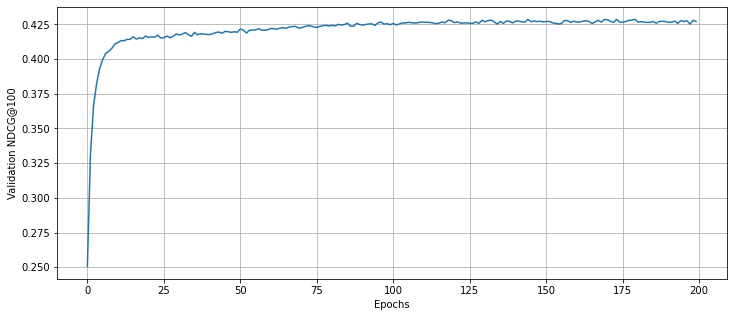

In [60]:
#print(r50_List)# 
plt.figure(figsize=(12, 5))
plt.plot(ngdc_List)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
plt.grid(True)

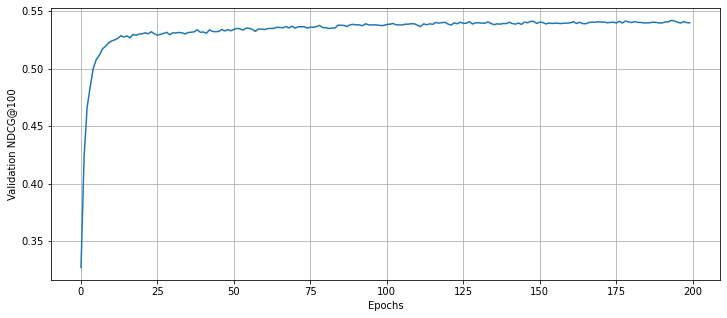

In [62]:
#print(r50_List)# 
plt.figure(figsize=(12, 5))
plt.plot(r50_List)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
plt.grid(True)

In [127]:


# def getpred_list(model_,trainMat,best_BS,test_BS,n_epoch, k=10):
#     TrainSample = DataSampler(trainMat,batch_size=best_BS, shuffle=False)  #train_data
#     model_.train(TrainSample, valid_data=None,num_epochs=n_epoch)
#     All_userpred = []    
#     pred_sample = DataSampler(trainMat, batch_size=test_BS, shuffle=False)  #train_data
#     for batch_idx, (data, gt) in enumerate(pred_sample):
#         input_data = data
#         data_tensor = data.view(input_data.shape[0], -1).to(device)
#         pred_out = model_.predict(data_tensor,remove_train=False)
#         predOut_ = pred_out[0].to('cpu')
#         #idx = bn.argpartition(-predOut_, k-1, axis=1)
#         idx_topk_part = bn.argpartition(-predOut_, k-1, axis=1)
#         topk_part = predOut_[np.arange(predOut_.shape[0])[:, np.newaxis], idx_topk_part[:, :k]]
#         idx_part = np.argsort(-topk_part, axis=1)
#         idx_topk = idx_topk_part[np.arange(predOut_.shape[0])[:, np.newaxis], idx_part]
#         All_userpred.append(idx_topk)
#     All_UserPRED = np.vstack(All_userpred)
#     return All_UserPRED



# def getVAE_TopNPred(X_out,k):   ##X_out == tensor output from model
#     batch_users = X_out.shape[0]
#     idx_topk_part = bn.argpartition(-X_out, k, axis=1)
#     topk_part = X_out[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
#     idx_part = np.argsort(-topk_part, axis=1)
#     idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
#     return idx_topk       

In [64]:
import pickle

with open('/home/oolaleke/incremental_PSI/Notebooks/MLDF20M_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)

with open('/home/oolaleke/incremental_PSI/Notebooks/MLDF20M_newPSITest.pkl', 'rb') as f:
     newPSITest_list = pickle.load(f)     
    
with open('/home/oolaleke/incremental_PSI/Notebooks/MLDF20M_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)


In [65]:
rows_i = newMLDF_20M['Updated_UserID'].nunique()
cols_i = newMLDF_20M['Updated_ItemID'].nunique()
UserItem_MATList = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
print(len(UserItem_MATList))   
UserItem_MATList

15


[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8865107 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8945455 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9025842 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9106051 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9186201 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9266468 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9346597 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9426837 stored elements in Compres

In [377]:
I =  newMLDF_20M['Updated_ItemID'].nunique()  #I is the total number of items in the train date
#I = len(train_Items) 
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)


init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=20720, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=20720, bias=True)
    )
  )
)

In [131]:
for epoch in tqdm(range(100)):
    train_step(VAEmodel, optimizer, UserItem_MATList[0], epoch)


100%|██████████| 100/100 [20:10<00:00, 12.11s/it]


In [ ]:
if epoch % args.eval_every == (args.eval_every - 1):
            val_loss, n100, r20, r50 = eval_step(valid_data_tr, valid_data_te)

In [132]:
heldout_users = newHoldout_list[0]['Updated_UserID']
print(heldout_users.shape)
holdout_Mat1 =  SingleRatingMatrix(newHoldout_list[-1],'Updated_UserID','Updated_ItemID',rows_i,cols_i)
Holdout_Mat1 = holdout_Mat1[heldout_users,:] 
Holdout_Mat1

(3459,)


<3459x20720 sparse matrix of type '<class 'numpy.float64'>'
	with 611 stored elements in Compressed Sparse Row format>

In [368]:
def topN_Index(a, n):
    parted = np.argpartition(a, -n)[-n:]
    return parted[np.argsort(-a[parted])]  


def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):  #Hello2021
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    # build the discount template
    tp = 1.0 / np.log2(np.arange(2, k + 2))
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[: min(n, k)]).sum() for n in heldout_batch.getnnz(axis=1)])
    return DCG[IDCG > 0.0] / IDCG[IDCG > 0.0]


def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(np.float32)
    denominator = np.minimum(k, X_true_binary.sum(axis=1))
    recall = tmp[denominator > 0.0] / denominator[denominator > 0.0]
    return recall

def HR_at_k_batch(pred_scores, ground_truth, k=10):  #"pred_scores' and 'ground_truth' must have the same shape."
    k = min(pred_scores.shape[1], k)
    idx = bn.argpartition(-pred_scores, k-1, axis=1)
    pred_scores_binary = np.zeros_like(pred_scores, dtype=bool)
    pred_scores_binary[np.arange(pred_scores.shape[0])[:, np.newaxis], idx[:, :k]] = True
    X_true_binary = (ground_truth > 0)
    num = (np.logical_and(X_true_binary, pred_scores_binary).sum(axis=1)).astype(np.float32)
    return num > 0
   
def MRR_at_k_batch(pred_scores, ground_truth, k=10):  #'pred_scores' and 'ground_truth' must have the same shape
       #Compute the Mean Reciprocal Rank (MRR)             
    k = min(pred_scores.shape[1], k)
    idx = np.argsort(-pred_scores)
    hits = ground_truth[np.arange(ground_truth.shape[0])[:, np.newaxis], idx[:, :k]]
    rranks, cranks = hits.nonzero()

    mrr = [0. for _ in range(ground_truth.shape[0])]
    for i, r in enumerate(rranks):
        if mrr[r] == 0:
           mrr[r] = 1. / (1 + cranks[i])

    return np.array(mrr)


In [381]:
def get_eval(model,data_tr):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list, topn_list = [], [], [],[]
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()     
             n100 =  NDCG_binary_at_k_batch(X_out, X_tr, k=100)
             hr10 =  HR_at_k_batch(X_out, X_tr.toarray(), k=10)   # #X_tr.toarray() == groundTruth
             mrr10 = MRR_at_k_batch(X_out, X_tr.toarray(), k=10)

             topn_list.append(topN_pred)
             n100_list.append(n100)   
             hr10_list.append(hr10)
             mrr10_list.append(mrr10)
                
    n100_list = np.concatenate(n100_list)
    hr10_list = np.concatenate(hr10_list)
    mrr10_list = np.concatenate(mrr10_list)
    topn_list=  np.concatenate(topn_list)
    return np.mean(n100_list), np.mean(hr10_list), np.mean(mrr10_list)


def getPred_(model,data_tr,batch_size,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()        #X_out[X_tr.nonzero()] = -np.inf
             topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = 10) 
             #batch_users = X_out.shape[0]
             #idx_topk_part = bn.argpartition(-X_out, k, axis=1)##Not this
             #topk_part = X_out[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]  
             #idx_part = np.argsort(-topk_part, axis=1)   ##Not this
             #idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]      
             users_pred.append(topN_pred)
        
         AllUserPRED = np.vstack(users_pred)
    return AllUserPRED 


In [386]:
def singlestep_predEval(model_,UserItemMat,holdout_Mat,pred_BS,n_epoch):
    for epoch in range(n_epoch):
        train_step(model_, optimizer, UserItemMat, epoch)
    
    n100, hr10,mrr10 = get_eval(model_,holdout_Mat)
    allUserPRED = getPred_(model_,UserItemMat,batch_size=pred_BS,k=10)
    return  n100, hr10,mrr10,allUserPRED

def Allsteps_predEval(model_,UserItemMatList,holdout_MatList,pred_BS,n_epoch):   
    n100_List = []
    hr10_List = [] 
    mrr10_List = [] 
    ALLUsers_Pred = []
    for UserItemMat,holdout_Mat in tqdm(zip(UserItemMatList,holdout_MatList)):
        n100, hr10,mrr10,allUserpred_ = singlestep_predEval(model_,UserItemMat,holdout_Mat,pred_BS,n_epoch)
        n100_List.append(n100)
        hr10_List.append(hr10)   
        mrr10_List.append(mrr10)
        ALLUsers_Pred.append(allUserpred_)
        print("| HitRate  {:4.3f} | NDGC100 {:4.3f} | Mrr {:4.3f} | ".format(hr10, n100, mrr10))
    return n100_List,hr10_List,mrr10_List ,ALLUsers_Pred 

In [370]:
 n100, hr10,mrr10 = get_eval(VAEmodel,Holdout_Mat1)
 print(n100,hr10, mrr10)

0.37974422097264454 0.06764960971379011 0.06687867399055603


In [371]:
AllUserPRED_1 = getPred_(VAEmodel,UserItem_MATList[0],batch_size=3000,k=10)
print(AllUserPRED_1.shape)
AllUserPRED_1

(136677, 10)


array([[1039,   10,  105, ...,  912,  108, 1129],
       [ 135,  268, 1251, ..., 1062,  105,  746],
       [ 352,  869,   89, ...,   78,  865,  473],
       ...,
       [  78,  149,   20, ...,  861,  268,   58],
       [  78,  149,   20, ...,  861,  268,   58],
       [  78,  149,   20, ...,  861,  268,   58]])

In [373]:
def get_holdoutRatMat(Holdout_MATList,newHoldout_list):
    HOLDOUT_MATList = []
    for holdoutMAT, holdout_df in zip(Holdout_MATList,newHoldout_list):
        heldout_users = holdout_df['Updated_UserID']
        Holdout_Mat = holdoutMAT[heldout_users,:] 
        HOLDOUT_MATList.append(Holdout_Mat)
    return  HOLDOUT_MATList

In [374]:
rows_i = newMLDF_20M['Updated_UserID'].nunique()
cols_i = newMLDF_20M['Updated_ItemID'].nunique()
holdout_MATList_1 = AllRatingMatrices(newHoldout_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 

HOLDOUT_MATList = get_holdoutRatMat(holdout_MATList_1,newHoldout_list)
print(len(HOLDOUT_MATList))   
HOLDOUT_MATList

15


[<3459x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 3459 stored elements in Compressed Sparse Row format>,
 <3311x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 3311 stored elements in Compressed Sparse Row format>,
 <3124x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 3124 stored elements in Compressed Sparse Row format>,
 <3115x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 3115 stored elements in Compressed Sparse Row format>,
 <3165x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 3165 stored elements in Compressed Sparse Row format>,
 <3098x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 3098 stored elements in Compressed Sparse Row format>,
 <3169x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 3169 stored elements in Compressed Sparse Row format>,
 <3129x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 3129 stored elements in Compressed Sparse Row format>,
 <3192x20720 spa

In [387]:
I =  newMLDF_20M['Updated_ItemID'].nunique()  #I is the total number of items in the train date
#I = len(train_Items) 
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)


init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=20720, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=20720, bias=True)
    )
  )
)

In [388]:
n100_List,hr10_List,mrr10_List ,ALLUsers_Pred  = Allsteps_predEval(VAEmodel,UserItem_MATList,HOLDOUT_MATList,pred_BS=3000,n_epoch=200)
print(hr10_List)
print(mrr10_List) 

1it [41:10, 2470.87s/it]| HitRate  0.912 | NDGC100 0.898 | Mrr 0.888 | 
2it [1:22:17, 2468.17s/it]| HitRate  0.908 | NDGC100 0.894 | Mrr 0.882 | 
3it [2:03:27, 2469.24s/it]| HitRate  0.917 | NDGC100 0.906 | Mrr 0.896 | 
4it [2:44:42, 2471.45s/it]| HitRate  0.916 | NDGC100 0.904 | Mrr 0.895 | 
5it [3:25:55, 2472.05s/it]| HitRate  0.898 | NDGC100 0.888 | Mrr 0.878 | 
6it [4:07:11, 2473.25s/it]| HitRate  0.907 | NDGC100 0.896 | Mrr 0.887 | 
7it [4:48:25, 2473.67s/it]| HitRate  0.900 | NDGC100 0.891 | Mrr 0.884 | 
8it [5:29:44, 2475.26s/it]| HitRate  0.877 | NDGC100 0.861 | Mrr 0.851 | 
9it [6:11:05, 2477.06s/it]| HitRate  0.893 | NDGC100 0.881 | Mrr 0.872 | 
10it [6:52:24, 2477.73s/it]| HitRate  0.908 | NDGC100 0.896 | Mrr 0.887 | 
11it [7:46:56, 2720.69s/it]| HitRate  0.906 | NDGC100 0.900 | Mrr 0.891 | 
12it [8:42:01, 2898.60s/it]| HitRate  0.883 | NDGC100 0.873 | Mrr 0.862 | 
13it [10:31:31, 4010.79s/it]| HitRate  0.887 | NDGC100 0.883 | Mrr 0.874 | 
14it [11:12:14, 3537.17s/it]| HitRa

In [408]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_20VAE_allPRED_NEW.pkl', 'wb') as f:
     pickle.dump(ALLUsers_Pred, f)

In [391]:
#Hello2021  
ALLUsers_Pred[:2]

[array([[1039,  978, 1041, ..., 1003, 1053,   20],
        [  20,  663,  268, ...,  969, 1062,   78],
        [ 865,   89,    7, ...,   78,   87,   20],
        ...,
        [  78,   76,   92, ..., 2378,  268,  861],
        [  78,   76,   92, ..., 2378,  268,  861],
        [  78,   76,   92, ..., 2378,  268,  861]]),
 array([[1039, 1139,  979, ...,  108,  135, 1053],
        [ 135,   20,  268, ...,  746,   14,   95],
        [ 865,   89,  206, ...,  352,   20,   92],
        ...,
        [  78,   76,  149, ...,   20,  861,   15],
        [  78,   76,  149, ...,   20,  861,   15],
        [  78,   76,  149, ...,   20,  861,   15]])]

In [392]:
hr10_List

[0.9118242266551027,
 0.9075807913017215,
 0.9170934699103713,
 0.9162118780096308,
 0.89826224328594,
 0.907036797934151,
 0.899652887346166,
 0.8772770853307766,
 0.893170426065163,
 0.9081842182458199,
 0.90633608815427,
 0.8830029249268768,
 0.887085137085137,
 0.8732980332829047,
 0.906959706959707]

In [393]:
mrr10_List

[0.8883169968382457,
 0.8822516815041731,
 0.8962121212121212,
 0.8948692960330199,
 0.8782876952782166,
 0.8866428161537909,
 0.8835487134792909,
 0.8507359468768864,
 0.8719388998289375,
 0.887305195863424,
 0.8914368553257441,
 0.8621993180329223,
 0.8739458072791405,
 0.8555228369713997,
 0.882041107041107]

In [407]:
VAE_CovList = AllSteps_Coverage_Ratio(newMLDF_20M,ALLUsers_Pred,'Updated_ItemID')
VAE_CovList

[0.601158,
 0.614575,
 0.622876,
 0.637597,
 0.646139,
 0.653764,
 0.658446,
 0.671139,
 0.677317,
 0.680068,
 0.69194,
 0.691844,
 0.674759,
 0.691409,
 0.691071]

In [401]:
AllSteps = list(range(1,15))
print(len(AllSteps))   #Hello2021
AllSteps  

14


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [402]:
VAECorr_ = Updt_getAll_AvgCorr(ALLUsers_Pred,newUserItem_list,AllSteps,'Updated_UserID')  #,
VAECorr_

array([array([0.59779197, 0.48840492, 0.52216952, ..., 0.33689549, 0.30510123,
              0.5327588 ])                                                    ,
       array([0.43376068, 0.39659413, 0.25869714, ..., 0.49458338, 0.70010365,
              0.22506224])                                                    ,
       array([0.26063194, 0.51017903, 0.35282258, ..., 0.26974024, 0.21869066,
              0.39290432])                                                    ,
       array([0.44498825, 0.47738191, 0.22121112, ..., 0.        , 0.02928462,
              0.0476934 ])                                                    ,
       array([0.48570853, 0.50909834, 0.18617919, ..., 0.08488278, 0.17785047,
              0.34973027])                                                    ,
       array([0.28164612, 0.4539545 , 0.39950702, ..., 0.35530665, 0.15337136,
              0.        ])                                                    ,
       array([0.35804968, 0.57092689, 0.310779

In [403]:
print(VAECorr_.shape)
for df in VAECorr_:
    print(df.mean())    

(14,)
0.4379622873056649
0.44578233753296326
0.4470349665368006
0.4502740666650557
0.446952496896618
0.45243219313352456
0.44677650769609084
0.4622952622012326
0.4548614262659261
0.4458771262177781
0.45360080691317306
0.43744373841495576
0.4319638455632983
0.4403407751007617


In [398]:
heldout_users = newHoldout_list[0]['Updated_UserID']
userpred_1 = ALLUsers_Pred[0][heldout_users,:]
print(userpred_1.shape)  
userpred_1

(3459, 10)


array([[11105,  7897,  9633, ...,  3648,  9384,  5780],
       [10297,  8508,  8532, ...,   828,  7899,  9067],
       [  135,  1052,  4059, ...,  5713,  4750,   149],
       ...,
       [ 3549,   807,   734, ...,  2203,  1502,   124],
       [15156, 11068,  8374, ...,  8445,    92,    78],
       [ 8445,  6856,  6918, ...,  7596,  5991,  2501]])

In [400]:
for holdout_df,allpred in zip(newHoldout_list,ALLUsers_Pred):
    heldout_users = holdout_df['Updated_UserID']
    userpred_1 = allpred[heldout_users,:]
    Hitrate_Eval(holdout_df,userpred_1,'Updated_UserID','Updated_ItemID') 
    print() 

Number of hits:  77
Total Num of users:  3459
Recommendation HitRate:  0.022260769008383925

Number of hits:  57
Total Num of users:  3311
Recommendation HitRate:  0.017215342796738146

Number of hits:  58
Total Num of users:  3124
Recommendation HitRate:  0.01856594110115237

Number of hits:  67
Total Num of users:  3115
Recommendation HitRate:  0.021508828250401284

Number of hits:  51
Total Num of users:  3165
Recommendation HitRate:  0.016113744075829384

Number of hits:  49
Total Num of users:  3098
Recommendation HitRate:  0.0158166559070368

Number of hits:  40
Total Num of users:  3169
Recommendation HitRate:  0.012622278321236984

Number of hits:  65
Total Num of users:  3129
Recommendation HitRate:  0.020773410035155003

Number of hits:  81
Total Num of users:  3192
Recommendation HitRate:  0.02537593984962406

Number of hits:  79
Total Num of users:  3409
Recommendation HitRate:  0.023173951305368142

Number of hits:  75
Total Num of users:  3267
Recommendation HitRate:  0.0

In [399]:
Hitrate_Eval(newHoldout_list[0],userpred_1,'Updated_UserID','Updated_ItemID')

Number of hits:  77
Total Num of users:  3459
Recommendation HitRate:  0.022260769008383925


0.022260769008383925

In [347]:
batch_users = X_pred.shape[0]
idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],idx_topk_part[:, :k]]
idx_part = np.argsort(-topk_part, axis=1)
# X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted  topk predicted score
idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
print(idx_topk.shape) 
idx_topk  

(136677, 10)


array([[1039,   10,  105, ...,  912,  108, 1129],
       [ 135,  268, 1251, ..., 1062,  105,  746],
       [ 352,  869,   89, ...,   78,  865,  473],
       ...,
       [  78,  149,   20, ...,  861,  268,   58],
       [  78,  149,   20, ...,  861,  268,   58],
       [  78,  149,   20, ...,  861,  268,   58]])

In [348]:
test_pred_2 = idx_topk[heldout_users,:]
print(test_pred_2.shape)
test_pred_2

(3459, 10)


array([[11105,  8252,  7113, ...,  7060,  8005, 12999],
       [10152,  5892,  1521, ...,  6663,  3410,  7932],
       [  135,  1052,  2477, ...,  4724,  2841,  4648],
       ...,
       [  734,  2203,  3549, ...,  1918,  2578,   807],
       [11068, 14445,  2340, ..., 11887,  8445,    92],
       [ 8445,  6856,  4838, ...,  5551,  5991,  9170]])

In [339]:
test_pred = AllUserPRED_1[heldout_users,:]
print(test_pred.shape)
test_pred

(3459, 10)


array([[11105,  8252,  7113, ...,  7060,  8005, 12999],
       [10152,  5892,  1521, ...,  6663,  3410,  7932],
       [  135,  1052,  2477, ...,  4724,  2841,  4648],
       ...,
       [  734,  2203,  3549, ...,  1918,  2578,   807],
       [11068, 14445,  2340, ..., 11887,  8445,    92],
       [ 8445,  6856,  4838, ...,  5551,  5991,  9170]])

In [315]:
AllUserPRED_1 =  getPred_(VAEmodel,Holdout_Mat1,k=10)   ##Hello2021
print(AllUserPRED_1.shape)
AllUserPRED_1

(3459, 10)


array([[ 78,  20, 149, ..., 861, 268,  58],
       [ 78, 149, 105, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58],
       ...,
       [ 78, 149,  20, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58]])

In [311]:
 topN_pred = np.apply_along_axis(topN_Index, 1, AllUserPRED_1,n = 10)
 topN_pred

array([[ 78,  20, 149, ..., 861, 268,  58],
       [ 78, 149, 105, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58],
       ...,
       [ 78, 149,  20, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58]])

In [349]:
Hitrate_Eval(newHoldout_list[0],test_pred_2,'Updated_UserID','Updated_ItemID')

Number of hits:  84
Total Num of users:  3459
Recommendation HitRate:  0.024284475281873375


0.024284475281873375

In [ ]:
def HR_at_k_batch(pred_scores, ground_truth, k=10):  #"pred_scores' and 'ground_truth' must have the same shape."
    k = min(pred_scores.shape[1], k)
    idx = bn.argpartition(-pred_scores, k-1, axis=1)
    pred_scores_binary = np.zeros_like(pred_scores, dtype=bool)
    pred_scores_binary[np.arange(pred_scores.shape[0])[:, np.newaxis], idx[:, :k]] = True
    X_true_binary = (ground_truth > 0)
    num = (np.logical_and(X_true_binary, pred_scores_binary).sum(axis=1)).astype(np.float32)
    return num > 0
 

In [305]:
k =10
idx = bn.argpartition(-AllUserPRED_1[0], k-1, axis=1)
print(idx.shape)
idx

(3459, 20720)


array([[   20,    78,   149, ..., 20717, 20718, 20719],
       [  135,   149,    20, ..., 20717, 20718, 20719],
       [  861,    76,    78, ..., 20717, 20718, 20719],
       ...,
       [  861,    76,    78, ..., 20717, 20718, 20719],
       [  861,    76,    78, ..., 20717, 20718, 20719],
       [  861,    76,    78, ..., 20717, 20718, 20719]])

In [250]:
 pred_scores_binary = np.zeros_like(AllUserPRED_1, dtype=bool)
 print(pred_scores_binary.shape)
 pred_scores_binary

(3459, 20720)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [251]:
pred_scores_binary[np.arange(AllUserPRED_1.shape[0])[:, np.newaxis], idx[:, :k]] = True
pred_scores_binary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [252]:
pred_scores_binary.shape

(3459, 20720)

In [231]:
idx_topk_part = bn.argpartition(-AllUserPRED_1, 10, axis=1)
print(idx_topk_part.shape)
idx_topk_part

(3459, 20720)


array([[   78,   135,   149, ..., 20717, 20718, 20719],
       [   78,   149,   105, ..., 20717, 20718, 20719],
       [   78,   135,    92, ..., 20717, 20718, 20719],
       ...,
       [   78,   135,    92, ..., 20717, 20718, 20719],
       [   78,   135,    92, ..., 20717, 20718, 20719],
       [   78,   135,    92, ..., 20717, 20718, 20719]])

In [232]:
topk_part = AllUserPRED_1[np.arange(3459)[:, np.newaxis], idx_topk_part[:, :10]]
print(topk_part.shape)
topk_part

(3459, 10)


array([[9.684198 , 9.235962 , 9.341442 , ..., 9.215929 , 9.061156 ,
        9.23575  ],
       [9.702471 , 9.361824 , 9.354693 , ..., 9.254975 , 9.093869 ,
        9.243983 ],
       [9.7205715, 9.309681 , 9.252223 , ..., 9.217798 , 9.379328 ,
        9.096189 ],
       ...,
       [9.7205715, 9.309681 , 9.252223 , ..., 9.217798 , 9.379328 ,
        9.096189 ],
       [9.7205715, 9.309681 , 9.252223 , ..., 9.217798 , 9.379328 ,
        9.096189 ],
       [9.7205715, 9.309681 , 9.252223 , ..., 9.217798 , 9.379328 ,
        9.096189 ]], dtype=float32)

In [234]:
idx_part = np.argsort(-topk_part, axis=1)
print(idx_part.shape)
idx_part

(3459, 10)


array([[0, 4, 2, ..., 7, 6, 8],
       [0, 1, 2, ..., 5, 6, 8],
       [0, 8, 5, ..., 7, 3, 9],
       ...,
       [0, 8, 5, ..., 7, 3, 9],
       [0, 8, 5, ..., 7, 3, 9],
       [0, 8, 5, ..., 7, 3, 9]])

In [245]:
idx_topk = idx_topk_part[np.arange(3459)[:, np.newaxis], idx_part] 
print(idx_topk.shape)
idx_topk

(3459, 10)


array([[ 78,  20, 149, ..., 861, 268,  58],
       [ 78, 149, 105, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58],
       ...,
       [ 78, 149,  20, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58]])

In [ ]:
#batch_users = X_out.shape[0]
#idx_topk_part = bn.argpartition(-X_out, k, axis=1)##Not this
#topk_part = X_out[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]  
             #idx_part = np.argsort(-topk_part, axis=1)   ##Not this
             #idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]  

In [201]:
print(AllUserPRED_1.shape)
AllUserPRED_1

(3459, 10)


array([[ 78,  20, 149, ..., 861, 268,  58],
       [ 78, 149, 105, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58],
       ...,
       [ 78, 149,  20, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58],
       [ 78, 149,  20, ..., 861, 268,  58]])

In [ ]:

def Hitrate_Eval(Holdout,TopN_pred,user_column,item_column):
    Eval_itemsVector  =  Holdout[[item_column]].to_numpy()
    HitRate_arr   =  (TopN_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    print("Number of hits: ", HitCount)
    print("Total Num of users: ",len(Holdout[user_column]))
    print("Recommendation HitRate: ",HitRate_)
    return HitRate_

In [304]:
Hitrate_Eval(newHoldout_list[0],topN_pred,'Updated_UserID','Updated_ItemID')

Number of hits:  83
Total Num of users:  3459
Recommendation HitRate:  0.023995374385660597


0.023995374385660597

In [323]:
MRR_Eval(newHoldout_list[0],test_pred,'Updated_ItemID')

0.005352381870161575

In [ ]:
def MRR_Eval(Holdout,TopN_pred,item_column):
    Ntest_users = Holdout.shape[0]
    Eval_itemsVector  =  Holdout[[item_column]].to_numpy()
    item_pos = np.where(Eval_itemsVector == TopN_pred)[1] +1  #eval item pos in pred_index1 
    if item_pos.size:  ##if any hit
       Hit_RR = (1/item_pos)  
       MRR_ = np.divide(np.sum(Hit_RR),Ntest_users)  #mean of all reciprocal rank
       return MRR_    
    return 0

In [136]:
if epoch % eval_every == (eval_every - 1):
            val_loss, n100, r20, r50 = eval_step(valid_data_tr, valid_data_te)

NameError: name 'args' is not defined

In [ ]:
    val_loss, n100, r50 = eval_step(VAEmodel,ValidTrain_RatMat, ValidTest_RatMat)  
    ngdc_List.append(n100)
    r50_List.append(r50)
    print("| valid loss {:4.3f} | n100 {:4.3f} | r50 {:4.3f} | ".format(val_loss, n100, r50))
            

ngdc_List            

In [ ]:
def train_step_2(model, optimizer, data,total_anneal_steps,epoch):
    model.train()
    running_loss = 0.0
    global update_count
    N = data.shape[0]
    idxlist = list(range(N))
    np.random.shuffle(idxlist)
    t = len(range(0, N, batch_size))   #training_steps
    for batch_idx, start_idx in zip(range(t), range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        X_inp = data[idxlist[start_idx:end_idx]]
        X_inp = torch.FloatTensor(X_inp.toarray()).to(device)
        if constant_anneal:
           anneal = anneal_cap
        else:
             anneal = min(anneal_cap, update_count/total_anneal_steps)
        update_count += 1
        optimizer.zero_grad()
        X_out, mu, logvar = model(X_inp)
        loss = vae_loss_fn(X_inp, X_out, mu, logvar, anneal)
        train_step_2.anneal = anneal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        avg_loss = running_loss / (batch_idx + 1)
        #t.set_postfix(loss=avg_loss)
        #return model

def eval_step_2(model,data_tr, data_te):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_te = data_te[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)

             X_out, mu, logvar = model(X_tr_inp)
             loss = vae_loss_fn(X_tr_inp, X_out, mu, logvar, train_step_2.anneal)
             running_loss += loss.item()
             avg_loss = running_loss / (batch_idx + 1)

             #Exclude examples from training set
             X_out = X_out.cpu().numpy()
             X_out[X_tr.nonzero()] = -np.inf

             n100 = NDCG_binary_at_k_batch(X_out, X_te, k=100)
             n100_list.append(n100)
         n100_list = np.concatenate(n100_list)
         avg_NDCG = np.mean(n100_list)
    return avg_loss, avg_NDCG   

def getTot_annealSTeps(train_RatMat,batch_size,n_epochs,anneal_cap):
    training_steps = len(range(0, train_RatMat.shape[0], batch_size))
    try:
       total_anneal_steps = (training_steps * (n_epochs - int(n_epochs * 0.2))) / anneal_cap  ##
    except ZeroDivisionError:
        assert (constant_anneal), "if 'anneal_cap' is set to 0.0 'constant_anneal' must be set to 'True"

    return total_anneal_steps

    
def Tuning(model,train_set,validtrain_set,validtest_set,als_param_grid,n_epochs,model_name,save_results= False):
    best_score = 0     ##based on MetricEval..
    stop_step = 0      
    for i in trange(len(als_param_grid)): 
        batch_size, lr_, weightdecay_ = list(als_param_grid)[i]
        total_anneal_steps = getTot_annealSTeps(train_set,batch_size,n_epochs,anneal_cap)
        Optimizer_ = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weightdecay_)
        print('batch_size = {} ,learning_rate = {}, weight_decay = {} '.format(batch_size,lr_,weightdecay_))
        model_2 = model
        for epoch in trange(n_epochs):            
            train_step_2(model_2, Optimizer_, train_set,total_anneal_steps,epoch)
            val_loss, curr_score = eval_step_2(model_2,validtrain_set,validtest_set)
            stop_step = stop_step + 1
           
            if (curr_score > best_score) & (save_results):
               best_epoch = epoch
               best_BS  = batch_size
               best_lr_ = lr_
               best_weightdecay_ = weightdecay_
               best_score = curr_score
               torch.save(model_2.state_dict(),model_name+".pth")
               stop_step = 0
               print('best_NGCG = {}, best_epoch = {}, stop_step = {} '.format(best_score,best_epoch,stop_step))

            if (stop_step > patience):
                print("Early Stop Activated...")
                print('epoch= {}, best_epoch = {}, curr_score = {}, best_score = {},Stop_Step = {}'.format(epoch, best_epoch,curr_score,best_score,stop_step))
                stop_step = 0
                break
               
        #print('NDCG100_ = {} '.format(best_NGCG100))

    print('\n Best parameters; batch_size= {}, lr_ = {}, weight_decay = {}, NDCG100_ = {}'.format(best_BS, best_lr_,best_weightdecay_,best_score))
    return best_BS, best_lr_, best_weightdecay_,best_score  


In [ ]:
class Encoder(nn.Module):
    def __init__(self, options, dropout_p=0.5, q_dims=[20108, 600, 200]):
        super(Encoder, self).__init__()
        self.options = options
        self.q_dims = q_dims

        self.dropout = nn.Dropout(p=dropout_p, inplace=False)
        self.linear_1 = nn.Linear(self.q_dims[0], self.q_dims[1], bias=True)
        self.linear_2 = nn.Linear(self.q_dims[1], self.q_dims[2] * 2, bias=True)
        self.tanh = nn.Tanh()

        for module_name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.normal_(0.0, 0.001)

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear_1(x)
        x = self.tanh(x)
        x = self.linear_2(x)
        mu_q, logvar_q = torch.chunk(x, chunks=2, dim=1)
        return mu_q, logvar_q

class Decoder(nn.Module):
    def __init__(self, options, p_dims=[200, 600, 20108]):
        super(Decoder, self).__init__()
        self.options = options
        self.p_dims = p_dims

        self.linear_1 = nn.Linear(self.p_dims[0], self.p_dims[1], bias=True)
        self.linear_2 = nn.Linear(self.p_dims[1], self.p_dims[2], bias=True)
        self.tanh = nn.Tanh()

        for module_name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.normal_(0.0, 0.001)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.tanh(x)
        x = self.linear_2(x)
        return x        

In [ ]:
class MultiVAE(nn.Module):
    def __init__(self, cuda2=True, weight_decay=0.0, dropout_p=0.5, q_dims=[20108, 600, 200], p_dims=[200, 600, 20108], n_conditioned=0):
        super(MultiVAE, self).__init__()
        self.cuda2 = cuda2
        self.weight_decay = weight_decay
        self.n_conditioned = n_conditioned
        self.q_dims = q_dims
        self.p_dims = p_dims
        self.q_dims[0] += self.n_conditioned
        self.p_dims[0] += self.n_conditioned

        self.encoder = Encoder(None, dropout_p=dropout_p, q_dims=self.q_dims)
        self.decoder = Decoder(None, p_dims=self.p_dims)

    def forward(self, x, c):
        x = f.normalize(x, p=2, dim=1)
        if self.n_conditioned > 0:
            x = torch.cat((x, c), dim=1)

        mu_q, logvar_q = self.encoder.forward(x)
        std_q = torch.exp(0.5 * logvar_q)
        KL = torch.mean(torch.sum(0.5 * (-logvar_q + torch.exp(logvar_q) + mu_q ** 2 - 1), dim=1))
        epsilon = torch.randn_like(std_q, requires_grad=False)
        if True:
            if self.training:
                sampled_z = mu_q + epsilon * std_q
            else:
                sampled_z = mu_q
        else:
            sampled_z = mu_q + epsilon * std_q

        if self.n_conditioned > 0:
            sampled_z = torch.cat((sampled_z, c), dim=1)
        logits = self.decoder.forward(sampled_z)

        return logits, KL, mu_q, std_q, epsilon, sampled_z

  def get_l2_reg(self):
        l2_reg = Variable(torch.FloatTensor(1), requires_grad=True)
        if self.weight_decay > 0:
            for k, m in self.state_dict().items():
                if k.endswith('.weight'):
                    l2_reg = l2_reg + torch.norm(m, p=2) ** 2
        if self.cuda2:
            l2_reg = l2_reg.cuda()
        return self.weight_decay * l2_reg[0]      

In [ ]:
class Trainer(object):

    def __init__(self, cmd, cuda, model, optim=None,
                 train_loader=None, valid_loader=None, test_loader=None, log_file=None,
                 interval_validate=1, lr_scheduler=None,
                 start_step=0, total_steps=1e5, beta=0.05, start_epoch=0,
                 total_anneal_steps=200000, anneal_cap=0.2, do_normalize=True,
                 checkpoint_dir=None, result_dir=None, print_freq=1, result_save_freq=1, checkpoint_freq=1):

        self.cmd = cmd
        self.cuda = cuda
        self.model = model

        self.optim = optim
        self.lr_scheduler = lr_scheduler

        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

        self.timestamp_start = datetime.datetime.now()

        if self.cmd == 'train':
            self.interval_validate = interval_validate

        self.start_step = start_step
        self.step = start_step
        self.total_steps = total_steps
        self.epoch = start_epoch

        self.do_normalize = do_normalize
        self.print_freq = print_freq
        self.checkpoint_freq = checkpoint_freq

        self.checkpoint_dir = checkpoint_dir

        self.total_anneal_steps = total_anneal_steps
        self.anneal_cap = anneal_cap

        self.n20_all = []
        self.n20_max_va, self.n100_max_va, self.r20_max_va, self.r50_max_va = 0, 0, 0, 0
        self.n20_max_te, self.n100_max_te, self.r20_max_te, self.r50_max_te = 0, 0, 0, 0



###Tuning

In [207]:
als_params = dict(batch_size = [50,100,200,300,500],
                  lr = [1e-7,1e-5,1e-3,1e-1],
                  weight_decay= [0.,0.1,0.2,0.3])

als_param_grid, als_param_names = random_grid(als_params, n=30)
print(als_param_names)
len(als_param_grid)                 

('batch_size', 'lr', 'weight_decay')


30

In [208]:
for i in range(10):
    batch_size, lr, weight_decay = list(als_param_grid)[i]  
    print(batch_size, lr, weight_decay)

50 1e-05 0.2
200 0.001 0.2
300 1e-05 0.2
100 0.1 0.3
500 0.001 0.1
300 0.001 0.2
100 1e-07 0.0
500 0.1 0.2
50 1e-05 0.1
200 0.001 0.1


6961

In [223]:
n_items = len(train_Items)   
I = n_items    ##I is the total number of items in the train date
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

                    
VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodel)
VAEmodel.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=3473, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=3473, bias=True)
    )
  )
)

In [215]:
from tqdm import trange

In [227]:
best_BS, best_lr_, best_weightdecay_,best_NGCG100 =  bestModelInfo
print("batch_size     :",best_BS)
print("learning_rate  :",best_lr_)
print("weight_decay   :",best_weightdecay_)
print("best_NGCG100   :",best_NGCG100)        

batch_size     : 300
learning_rate  : 1e-05
weight_decay   : 0.2
best_NGCG100   : 0.3835523654706246


In [228]:
# Run on test data with best model
#model.load_state_dict(torch.load(model_name + ".pt")))
VAEmodel.load_state_dict(torch.load('MLDF1M_VAE.pth'))
test_loss,tst_ndgc100_ = eval_step_2(VAEmodel,TestTrain_RatMat,TestTest_RatMat)
tst_ndgc100_

0.3877777527553243

###P_DimTuning

In [ ]:
def getVAEModel(n_items,p_dims):
    I = n_items    #I is the total number of items in the train date
    q_Dims = [I] + p_dims[::-1]
    P_Dims = p_dims + [I]
    dropout_enc = [0.5, 0.]
    dropout_dec = [0., 0.5]

    VAEmodel = MultiVAE(P_Dims,q_Dims,dropout_enc,dropout_dec)
    init_weights(VAEmodel)
    VAEmodel.to(device)
    return VAEmodel


def P_dimsTuning(train_set,validtrain_set,validtest_set,n_items,p_dimsList,model_name,n_epochs,save_results= True):
    update_count = 0
    best_score = 0     ##based on MetricEval..
    stop_step = 0
    update_count = 0
    stop = False
    patience_epoch = 25
    total_anneal_steps = getTot_annealSTeps(train_set,batch_size,n_epochs,anneal_cap)
    for p_dims in tqdm(p_dimsList):
        print("P_Dimensions: ",p_dims)
        model_ = getVAEModel(n_items,p_dims) 
        Optimizer_ = torch.optim.AdamW(model_.parameters(), lr=lr_, weight_decay=weightdecay_)
        for epoch in range(n_epochs):            
            train_step_2(model_, Optimizer_, train_set,total_anneal_steps,epoch)
            val_loss, NDCG100_ = eval_step_2(model_,validtrain_set,validtest_set)
            curr_score = NDCG100_
            best_score,stop_step,stop = early_stop(curr_score,best_score,stop_step,
                                           patience=patience_epoch,score_fn='metric')
            if stop:
                break
            if (stop_step == 0) & (save_results):
               best_epoch = epoch
               best_dims = p_dims
               best_NGCG100 = NDCG100_
               torch.save(model_.state_dict(),model_name+".pth")
               print('NDCG100_ = {} '.format(best_NGCG100))
               patience_epoch = epoch

        #print('NDCG100_ = {} '.format(best_NGCG100))

    print('\n Best parameters; Best_dims= {}, Best_NDCG100 = {}, Best_epoch = {}'.format(best_dims,best_NGCG100,best_epoch))
    return best_NGCG100,best_dims,best_epoch  



In [229]:
# anneal_epochs = None  
# anneal_cap = 0.2
# constant_anneal = False
# update_count = 0
# batch_size=200
# lr_=1e-5
# weightdecay_=0.1
# n_items = len(train_Items) 
# p_dimsList  = [[32,64],[64,128],[128,256],[256,512],[512,1024],[100,300],[200,600],[300,900]]


# best_ModelInfo2 = P_dimsTuning(TrainDF_RatMat,ValidTrain_RatMat,ValidTest_RatMat,n_items,p_dimsList,"AMZB_DimModel",n_epochs=200,save_results= True)

In [ ]:
newUserItem_list[0].columns  

Index(['userId', 'productId', 'Updated_UserID', 'Updated_ItemID'], dtype='object')

In [230]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
UserItem_MATList = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItem_MATList   

[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [251]:
 I =  newMLDF_1M['Updated_ItemID'].nunique()  #I is the total number of items in the train date
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

                    #p_dims,q_dims,dropout_enc,dropout_dec
VAEmodel_untrain = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodel_untrain)
VAEmodel_untrain.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=3533, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=3533, bias=True)
    )
  )
)

### Get Prediction

In [236]:
def Trainwith_Best(model,UserItem_TRset,best_BS,best_lr,best_wd):
    total_anneal_steps = getTot_annealSTeps(UserItem_TRset,best_BS,anneal_n,anneal_cap)
    Optimizer_ = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)
    for epoch in tqdm(range(bst_epochs)):            
        train_step_2(model, Optimizer_, UserItem_TRset,total_anneal_steps,epoch)
      
    #torch.save(model.state_dict(),model_name+".pth")
    return model

def get_ModelOut(X_train,model):  #X_train== RatMat...
    with torch.no_grad():
         X_input = torch.FloatTensor(X_train.toarray()).to(device)
         X_out, mu, logvar = model(X_input)
         X_out = X_out.cpu().numpy()         #convert from tensor to numpy
         X_out[X_train.nonzero()] = -np.inf  #Exclude examples from training set
    return X_out


def getVAE_TopNPred(X_out,k):   ##X_out == tensor output from model
    batch_users = X_out.shape[0]
    idx_topk_part = bn.argpartition(-X_out, k, axis=1)
    topk_part = X_out[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    return idx_topk

def getVAE_AllPred(model,UserItemList,best_BS,best_lr,best_wd,k=10):
    ALLstep_Pred  = []
    for UserItem_ in UserItemList:
        Trainedmodel = Trainwith_Best(model,UserItem_,best_BS,best_lr,best_wd)
        X_out = get_ModelOut(UserItem_,Trainedmodel)
        topNPred = getVAE_TopNPred(X_out,k)   ##get prediction for all users..
        ALLstep_Pred.append(topNPred)
    return ALLstep_Pred


def VAEHitrate_Eval_2(allPred,holdout,user_column,item_column):  ##N == Top_N
    TestUsers = holdout[user_column]
    HOLDOUT_pred = allPred[TestUsers,:] 
    Eval_itemsVector  = holdout[[item_column]].to_numpy()
    HitRate_arr   =  (HOLDOUT_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    print("Number of hits: ", HitCount)
    print("Total Num of users: ",len(holdout[user_column]))
    print("Recommendation HitRate: ",HitRate_)
    return HitRate_

def VAEHitrate_Eval(allPred,holdout,user_column,item_column):  ##N == Top_N
    TestUsers = holdout[user_column]
    HOLDOUT_pred = allPred[TestUsers,:] 
    Eval_itemsVector  = holdout[[item_column]].to_numpy()
    HitRate_arr   =  (HOLDOUT_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    return HitRate_

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    mean, se = np.mean(a), st.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    lower_band =  mean-h
    upper_band =  mean+h
    return lower_band, mean,upper_band                ##LowerBand || Mean || UpperBand



def getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column):
    AllSteps_Hitrate = []
    for holdout, allPred in zip(HOLDOUT_list,All_TOPN_PRED):                   
        HitRate_ = VAEHitrate_Eval_2(allPred,holdout,user_column,item_column)
        AllSteps_Hitrate.append(HitRate_)

    LowerBand, Avg_HitRate, UpperBand  = mean_confidence_interval(AllSteps_Hitrate, confidence=0.95)
    print("Average HitRate for All Recommendations: ", Avg_HitRate)
    return AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand    
       

In [233]:
print(best_BS, best_lr_, best_weightdecay_)

300 1e-05 0.2


In [252]:
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
update_count = 0
anneal_n = 200
bst_epochs = 100   #50
ALLstep_PredList =  getVAE_AllPred(VAEmodel_untrain,UserItem_MATList,best_BS,best_lr_,best_weightdecay_,k=10)

100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


In [253]:
print(len(ALLstep_PredList))   ##100
ALLstep_PredList[:2]

10


[array([[223, 221,  91, ..., 271,  59, 129],
        [221,  12,  19, ...,  40,  22,   2],
        [ 87,  22,  19, ..., 223,  59,   2],
        ...,
        [223, 221,  91, ...,  19, 271,  18],
        [ 19,  91, 261, ..., 478,   2,  87],
        [137,  24, 455, ...,  91,  62,  87]]),
 array([[223, 221, 261, ..., 461, 283, 271],
        [ 19, 223,   2, ...,  24, 156,  18],
        [ 19, 223,  87, ...,  22,  24, 455],
        ...,
        [221,   2, 223, ..., 461, 330,  18],
        [223,  87,  19, ...,  40, 221, 461],
        [ 40,  87, 223, ...,  22, 330,  19]])]

In [238]:
print(len(ALLstep_PredList))  ##50
ALLstep_PredList[:2]

10


[array([[  91,  223,  221, ...,  461,  408,   59],
        [  19,  261,  223, ...,   22,    2,   40],
        [ 223,   89,   73, ...,  312,   24,   27],
        ...,
        [2933,  170,  330, ...,  271,   19,  263],
        [ 100,   27,  695, ...,  332,   62,   15],
        [ 330,  556,  595, ...,  413,  112,   12]]),
 array([[261, 223,  62, ..., 455, 330, 283],
        [  2,  22, 221, ...,  24,  18, 330],
        [ 19, 223,   0, ...,  40,  87,  89],
        ...,
        [ 19,  91, 261, ...,  87,  12,  24],
        [ 87,  19, 283, ..., 330, 221,  15],
        [223,  19,  87, ..., 330,  73,  18]])]

In [246]:
with open('MLDF1M_VAEPredList.pkl', 'wb') as f:
     pickle.dump(ALLstep_PredList, f)


### HitRate_

In [239]:
newHOLDOUT_LIST[0].columns

Index(['userId', 'productId', 'Updated_UserID', 'Updated_ItemID'], dtype='object')

In [254]:
VAEHitrate_Eval_2(ALLstep_PredList[0],newHOLDOUT_LIST[0],'Updated_UserID', 'Updated_ItemID')

Number of hits:  10
Total Num of users:  233
Recommendation HitRate:  0.04291845493562232


0.04291845493562232

In [260]:
#getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column)
#getAll_VAEHitRate(newHOLDOUT_LIST,ALLstep_PredList,'Updated_UserID', 'Updated_ItemID')

In [241]:
#getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column)
getAll_VAEHitRate(newHOLDOUT_LIST,ALLstep_PredList,'Updated_UserID', 'Updated_ItemID')

Number of hits:  12
Total Num of users:  233
Recommendation HitRate:  0.05150214592274678
Number of hits:  7
Total Num of users:  255
Recommendation HitRate:  0.027450980392156862
Number of hits:  12
Total Num of users:  286
Recommendation HitRate:  0.04195804195804196
Number of hits:  8
Total Num of users:  309
Recommendation HitRate:  0.025889967637540454
Number of hits:  19
Total Num of users:  468
Recommendation HitRate:  0.0405982905982906
Number of hits:  22
Total Num of users:  526
Recommendation HitRate:  0.04182509505703422
Number of hits:  16
Total Num of users:  517
Recommendation HitRate:  0.030947775628626693
Number of hits:  20
Total Num of users:  470
Recommendation HitRate:  0.0425531914893617
Number of hits:  29
Total Num of users:  453
Recommendation HitRate:  0.0640176600441501
Number of hits:  15
Total Num of users:  362
Recommendation HitRate:  0.04143646408839779
Average HitRate for All Recommendations:  0.040817961281634715


([0.05150214592274678,
  0.027450980392156862,
  0.04195804195804196,
  0.025889967637540454,
  0.0405982905982906,
  0.04182509505703422,
  0.030947775628626693,
  0.0425531914893617,
  0.0640176600441501,
  0.04143646408839779],
 0.03270681252766698,
 0.040817961281634715,
 0.04892911003560245)

###Stability Check

In [242]:
AllSteps = list(range(1,10))
print(len(AllSteps))
AllSteps  

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [243]:
newUserItem_list[0].columns

Index(['userId', 'productId', 'Updated_UserID', 'Updated_ItemID'], dtype='object')

In [256]:
VAECorr_ = Updt_getAll_AvgCorr(ALLstep_PredList,newUserItem_list,AllSteps,'Updated_UserID')  #,
VAECorr_

array([array([0.74574267, 0.22293099, 0.30544747, ..., 0.23366204, 0.29627678,
              0.28320584])                                                    ,
       array([0.        , 0.08321104, 0.46201842, ..., 0.04457968, 0.03534858,
              0.04791652])                                                    ,
       array([0.23469388, 0.46057188, 0.25420561, ..., 0.35232686, 0.        ,
              0.20851412])                                                    ,
       array([0.24710653, 0.20722931, 0.5327588 , ..., 0.15626224, 0.13842832,
              0.57042553])                                                    ,
       array([0.31357893, 0.12386753, 0.46361293, ..., 0.36281388, 0.13449124,
              0.33653237])                                                    ,
       array([0.27698962, 0.04199901, 0.24311579, ..., 0.23614135, 0.09331951,
              0.16392021])                                                    ,
       array([0.42683163, 0.61739893, 0.123268

In [259]:
# print(VAECorr_.shape)
# for df in VAECorr_:
#     print(df.mean())  

In [258]:
# VAECorr_ = Updt_getAll_AvgCorr(ALLstep_PredList,newUserItem_list,AllSteps,'Updated_UserID')  #,
# VAECorr_

In [245]:
print(VAECorr_.shape)   #50
    print(df.mean())  

(9,)
0.39702879229666665
0.4157991349449941
0.43218495599712753
0.38141795006644386
0.3587914848103854
0.3869316534308683
0.34219130180373897
0.3519408456708518
0.36409856994483464


In [247]:
##mrr_
VAE_AllStepsMRR, VAE_LBand, VAE_AvgMRR, VAE_UBand  = getAll_VAEMRR(newHOLDOUT_LIST,ALLstep_PredList,'Updated_UserID','Updated_ItemID')
VAE_AllStepsMRR

10it [00:00, 565.12it/s]


[0.012876,
 0.008573,
 0.016909,
 0.012045,
 0.011844,
 0.018922,
 0.01007,
 0.015277,
 0.023361,
 0.017671]

In [248]:
print(VAE_LBand, VAE_AvgMRR, VAE_UBand)

0.011517135847101786 0.014754799999999998 0.01799246415289821


In [250]:
##Coverage...:
VAE_AvgCoverageList = AllSteps_Coverage_Ratio(newMLDF_1M,ALLstep_PredList,'Updated_ItemID')
VAE_AvgCoverageList

[0.22587,
 0.119445,
 0.115766,
 0.109539,
 0.105859,
 0.112652,
 0.122276,
 0.125106,
 0.159638,
 0.178319]